**Data analysis and Data Cleaning for the Financial Institutions Project**

**BNY Mellon Merger: 2007-07-02**

In [110]:
!pip install linearmodels > /dev/null 2>&1

The system cannot find the path specified.


In [111]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from linearmodels import PanelOLS
import statsmodels.api as sm
import matplotlib.ticker as ticker
from scipy import stats

def T_test_dummies(df1, df2, column, target_value):
    array_before = np.array([1 if value == target_value else 0 for value in df1[column]])
    array_after = np.array([1 if value == target_value else 0 for value in df2[column]])
    t_statistic, p_value = stats.ttest_ind(array_before, array_after)
    # If we dont need dummies
    # t_statistic, p_value = stats.ttest_ind(before["column], after["column])
    return t_statistic, p_value

"""example of the function being used:
T_test_dummies(management_sponsors_bny_before, management_sponsors_bny_mellon_after, "ISSrec", "For" )"""

def likelihood_function(df, column, value): # gives us relative % of something happening
    x = df[column].value_counts()[value]
    total = df[column].count()
    likelihood = x / total
    return likelihood

"""example of the likelyhood function being used:
likelihood_function(bank_of_ny_voting_before, "sponsor", "Shareholder")
"""

'example of the likelyhood function being used:\nlikelihood_function(bank_of_ny_voting_before, "sponsor", "Shareholder")\n'

In [109]:
import warnings
warnings.filterwarnings("ignore")

# Financial Data

comp = pd.read_csv('comp.csv')

# Loan Data
covenants = pd.read_csv('covenants.csv')
dealscan_compustat_linktable = pd.read_excel('dealscan_compustate linktable.xlsx')
facility = pd.read_csv('facility.csv')
lender_information = pd.read_csv('lender_information.csv',encoding='ISO-8859-1')
lendershares = pd.read_csv('lendershares.csv', encoding='ISO-8859-1')
package = pd.read_csv('package.csv', encoding='ISO-8859-1')
performancepricing  = pd.read_csv('performancepricing.csv')
pricing  = pd.read_csv('pricing.csv', encoding='ISO-8859-1')

# Voting Data
#iss_recomendations = pd.read_csv('iss recommendations.csv')
#voting_results = pd.read_csv('voting results.csv', encoding='ISO-8859-1')

Data filtering for BNY Mellon
---


In [112]:

# Merging Covenant types onto the Pakcage dataframe
covenant_compressed = covenants.copy()
covenant_compressed['CovenantType'] = covenant_compressed['CovenantType'].astype(str)
covenant_compressed = covenant_compressed.groupby('PackageID')['CovenantType'].agg(lambda x: ', '.join(set(x))).reset_index()
package = package.merge(covenant_compressed, how= "left", left_on='PACKAGEID', right_on='PackageID')
"""use this code later to analyzie the covenant types, since its a string"""
# num_ebitda = compressed_df['CovenantType'].str.contains('Min. Current Ratio').sum()

""" Pricing and performance pricing , ahve to be analyzed seperated, we shouldn't merge it onto
facility data, so we can just pull facility ids, and slice the dataframes, to have data we need
given the data, pre-post merger
"""

" Pricing and performance pricing , ahve to be analyzed seperated, we shouldn't merge it onto\nfacility data, so we can just pull facility ids, and slice the dataframes, to have data we need\ngiven the data, pre-post merger\n"

In [113]:
covenant_compressed

,PackageID,CovenantType
0,4106,"Min. Interest Coverage, Min. Current Ratio"
1,4812,Min. Current Ratio
2,4952,Max. Debt to EBITDA
3,5223,"Tangible Net Worth, Max. Senior Debt to EBITDA"
4,5287,Min. Interest Coverage
...,...,...
33248,306805,Max. Debt to EBITDA
33249,306855,"Max. Debt to EBITDA, Min. Fixed Charge Coverage"
33250,306895,Max. Debt to EBITDA
33251,306986,"Max. Debt to Equity, Min. Interest Coverage"


In [114]:
num_ebitda = covenant_compressed['CovenantType'].str.contains('Min. Current Ratio').sum()
num_ebitda

3964

**Determining all the banks id we need and subsidaries**

In [115]:
bank_ny_information = lender_information[lender_information['COMPANYID'] == 5851]
mellon_information = lender_information[lender_information['COMPANYID'] == 6014]

In [116]:
bank_ny_information

,COMPANYID,TICKER,CITY,COMPANY,COUNTRY,INSTITUTIONTYPE,PARENTID,PRIMARYSICCODE,PUBLICPRIVATE,REGION,SALES,SECONDARYSICCODE,STATE,TERTIARYSICCODE,ULTIMATEPARENTID,ZIPCODE
3577,5851,NaN,New York,Bank of New York,USA,US Bank,120119.0,6022.0,Private,North America,NaN,6153.0,New York,6082.0,120119.0,NaN


In [117]:
mellon_information

,COMPANYID,TICKER,CITY,COMPANY,COUNTRY,INSTITUTIONTYPE,PARENTID,PRIMARYSICCODE,PUBLICPRIVATE,REGION,SALES,SECONDARYSICCODE,STATE,TERTIARYSICCODE,ULTIMATEPARENTID,ZIPCODE
3665,6014,NaN,Pittsburgh,Mellon Bank,USA,US Bank,6547.0,6021.0,Private,North America,NaN,6159.0,Pennsylvania,6282.0,120119.0,NaN


In [118]:
"""we have to deternmine if we use ultimate parent ID or regular parent ID for subsidararies

ultimate has more!
"""
# subsidary company IDs
ny_subsidaries = lender_information[lender_information['PARENTID'] == 120119]
melon_subsidaries = lender_information[lender_information['PARENTID'] == 6547.0]

# Subsidary ID list
ny_subsidaries_IDs = ny_subsidaries["COMPANYID"].tolist()
melon_subsidaries_IDs = melon_subsidaries["COMPANYID"].tolist()

# Getting all the Facility IDs for Bank of NY and Mellon, also assessing the ones they were lead or not
lendershares

# All loans of our banks plus their respective subsidiraries (Lendershare database)
Mellon_bank_loans = lendershares[lendershares['COMPANYID'].isin(melon_subsidaries_IDs)]
NY_bank_loans = lendershares[lendershares['COMPANYID'].isin(ny_subsidaries_IDs)]

**Cleaning the facility data, to keep only loans we need**

In [119]:
# Cleaning Facility Data -> loan data
facility

# loans we want to keep
credit_lines = ['Revolver/Line >= 1 Yr.','Revolver/Line < 1 Yr.','364-Day Facility']
term_loans = ['Term Loan','Term Loan A', 'Term Loan B', 'Term Loan C', 'Term Loan D', 'Term Loan E',
              'Term Loan F', 'Term Loan G', 'Term Loan H', 'Term Loan I' ]
both_loans  = ['Revolver/Term Loan']
keep_loans = credit_lines + term_loans + both_loans

# Cleaned loan data
facility_cleaned = facility[facility['LOANTYPE'].isin(keep_loans)]
facility_cleaned

,BORROWERCOMPANYID,FACILITYID,PACKAGEID,TICKER,AVERAGELIFE,COMPANY,CONVERSIONDATE,COUNTRYOFSYNDICATION,CURRENCY,DISTRIBUTIONMETHOD,...,FACILITYSTARTDATE,LCLIMIT,LOANTYPE,MATURITY,PRIMARYPURPOSE,RENEWAL,SECONDARYPURPOSE,SECURED,SENIORITY,TARGETCOMPANY
0,14908,19735,14578,NaN,NaN,CenCall Communications Corp,NaN,USA,United States Dollars,NaN,...,19971231,NaN,Term Loan,54.0,Work. cap.,NaN,NaN,Yes,Senior,NaN
1,14908,19738,14578,NaN,NaN,CenCall Communications Corp,NaN,USA,United States Dollars,NaN,...,19971231,NaN,Term Loan,54.0,Work. cap.,NaN,NaN,Yes,Senior,NaN
2,2015,20145,14840,KOIL,NaN,Kelley Oil Corp,NaN,USA,United States Dollars,Sole Lender,...,19980824,NaN,Term Loan,24.0,Work. cap.,No,NaN,Yes,Senior,NaN
3,10909,24511,18185,NaN,NaN,Homedco Group,NaN,USA,United States Dollars,Syndication,...,19970503,NaN,Term Loan,24.0,Acquis. line,NaN,NaN,NaN,Senior,NaN
4,18232,28551,21170,NaN,NaN,Kumtor Gold Co,NaN,USA,United States Dollars,Syndication,...,19971010,NaN,Term Loan,60.0,Proj. finance,NaN,NaN,NaN,Senior,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91113,37025,434279,299626,NaN,NaN,Shamrock Foods,NaN,USA,United States Dollars,Syndication,...,20131001,NaN,Revolver/Line >= 1 Yr.,36.0,Corp. purposes,NaN,NaN,NaN,Senior,NaN
91114,95253,442576,304782,JBLU.O,NaN,JetBlue Airways Corp,NaN,USA,United States Dollars,Syndication,...,20130423,NaN,Revolver/Line >= 1 Yr.,36.0,Corp. purposes,NaN,NaN,Yes,Senior,NaN
91115,187829,443363,305342,NaN,NaN,CM Finance SPV Ltd,NaN,USA,United States Dollars,Syndication,...,20130523,NaN,Term Loan,55.0,Corp. purposes,NaN,NaN,NaN,Senior,NaN
91116,188114,445060,306448,NaN,NaN,BCH Pineridge LLC,NaN,USA,United States Dollars,Syndication,...,20120705,NaN,Term Loan,60.0,Real estate,NaN,NaN,NaN,Senior,NaN


In [120]:
""""" match facility to link, so we can get a gvkey then we can match it to the comp database, and in that database we will have borrwoer info

usually its the year before the facility start date (lag 1)


start year 1998, -> need to get data from 1997 ........ becaus ehtey looked at data in 1997
"""

# Matching facility data to gvkey, so finding out the loans we gave out to public borrowers


'"" match facility to link, so we can get a gvkey then we can match it to the comp database, and in that database we will have borrwoer info\n\nusually its the year before the facility start date (lag 1)\n\n\nstart year 1998, -> need to get data from 1997 ........ becaus ehtey looked at data in 1997\n'

**Our facilities**

In [121]:
# All Facilities loans for Mellon and Bank of NY
NY_facility = NY_bank_loans.merge(facility_cleaned, on='FACILITYID', how='inner')
mellon_facility = Mellon_bank_loans.merge(facility_cleaned, on='FACILITYID', how='inner')

# Spliting the loans if our banks were Lead Arranger or not
## Bank of New York: Lead vs Non-lead
NY_lead_loans= NY_facility[NY_facility['LEADARRANGERCREDIT'] == 'Yes']
NY_non_lead_loans= NY_facility[NY_facility['LEADARRANGERCREDIT'] == 'No']
## Mellon Bank: Lead vs Non-lead
Mellon_lead_loans= mellon_facility[mellon_facility['LEADARRANGERCREDIT'] == 'Yes']
Mellon_non_lead_loans= mellon_facility[mellon_facility['LEADARRANGERCREDIT'] == 'No']

**Getting all package ID for package analysis**

and fixing the datatime package date

In [122]:
# ALL our banks facilities IDs
## Bank of New York
NY_all_package_IDs = NY_facility["PACKAGEID"].tolist()
NY_lead_package_IDs = NY_lead_loans["PACKAGEID"].tolist()
NY_nonlead_package_IDs = NY_non_lead_loans["PACKAGEID"].tolist()
## Mellon Bank
mellon_all_package_IDs = mellon_facility["PACKAGEID"].tolist()
mellon_lead_package_IDs = Mellon_lead_loans["PACKAGEID"].tolist()
mellon_nonlead_package_IDs = Mellon_non_lead_loans["PACKAGEID"].tolist()

#
package['DEALACTIVEDATE'] = pd.to_datetime(package['DEALACTIVEDATE'], format='%Y%m%d')


**Getting all our respective package info**

dates are in the packages "DEALACTIVEDATE"


my loan data critera was based on when thenpackage was active, maybe it should be with the facility start and end date, conform with group our ask the Prof lin

In [123]:
# Bank of New York packages
NY_all_packages = package[package['PACKAGEID'].isin(NY_all_package_IDs)]
NY_lead_packages = package[package['PACKAGEID'].isin(NY_lead_package_IDs)]
NY_nonlead_packages = package[package['PACKAGEID'].isin(NY_nonlead_package_IDs)]
# Mellon Bank packages
mellon_all_packages = package[package['PACKAGEID'].isin(mellon_all_package_IDs)]
mellon_lead_packages = package[package['PACKAGEID'].isin(mellon_lead_package_IDs)]
mellon_nonlead_packages = package[package['PACKAGEID'].isin(mellon_nonlead_package_IDs)]

In [124]:
""""

Linked table for gvkey, to see if public and private borrowers,

I dont understand the table

See if someone understands it

    Linked table:

    For each facility ID, they link it to the “gvkey” which is from CompStat dataset

    This means that, if the facility ID that we found from bank of NY can be linked with this table to a gvkey, then that means the  its public, if it can not its private

    There’s facility ID & gvkey a link = public

    No link = private

    Thus now we can see, before and after, if they are lending more to public or private borrowers


we need this to see how risky the borrower is


"""

package.columns

Index(['BORROWERCOMPANYID', 'PACKAGEID', 'TICKER', 'ACTIVE', 'AGENTCONSENT',
       'ASSETSALESSWEEP', 'ASSIGNMENTFEE', 'ASSIGNMENTMIN',
       'ASSIGNMENTRESTRICTIONS', 'COLLATERALRELEASE', 'COMPANY',
       'COMPANYCONSENT', 'COMMENT', 'CURRENCY', 'DEALACTIVEDATE', 'DEALAMOUNT',
       'DEALPURPOSE', 'DEALSTATUS', 'DEBTISSUANCESWEEP', 'DEFAULTBASERATE',
       'DIVIDENDRESTRICTIONS', 'EQUITYISSUANCESWEEP', 'EXCESSCFSWEEP',
       'EXCHANGERATE', 'HYBRID', 'INSURANCEPROCEEDSSWEEP',
       'PERCENTAGEOFEXCESSCF', 'PERCENTAGEOFNETINCOME', 'PRORATAALLOCATION',
       'PROJECTFINANCETYPE', 'REFINANCINGINDICATOR', 'REQUIREDLENDERS',
       'SALESATCLOSE', 'SPREADOVERDEFAULTBASE', 'TERMCHANGES', 'PackageID',
       'CovenantType'],
      dtype='object')

**Date dependent pacakge IDs**

There are our packages, that we can do anaylis on, **important**

<u>merger on 2007-07-02*

Looking 3 years before : 2004, 2005, 2006

Looking 3 years afer : 2007, 2008, 2009</u>

    we can use the below dataframes for
    ackage is for us to compare it to the facility, because this is the actual loan, it’s the “deal”

    Within each Deal/package we have different things:

    Package ID: (its also in the other dataset)

    Deal amount: all the facilities together  

    Deal active date:  

    Deal purpose:  

    What’s interesting is if the Deal Purpose is not equal to the Facility purpose.  

    That might be something interesting to talk about if they say different things  

    Now, why do we care about loan package?

    Because Covenants are at the package level

AND MORE

In [125]:

# All years in the dataset - every year possible
NY_all_packages
NY_lead_packages
NY_nonlead_packages
mellon_all_packages
mellon_lead_packages
mellon_nonlead_packages

# 3 years before, 3 years after ... don't look at benchmark year of 2007, the merger
# Before merger [2004-2006]
before_start_date = pd.to_datetime('2004-01-01')
before_end_date = pd.to_datetime('2006-12-31')
# After merger [2008-2010]
after_start_date = pd.to_datetime('2008-01-01')
after_end_date = pd.to_datetime('2010-12-31')

"""these are package dataframe, we can do analysis on it
We can do our analysis on the packages below, important these are the dataframes we can do our analysis on
"""
# ALL packages: Lead + non lead
## 6 year interval we are looking at [2004-2010]
NY_packages_6y_interval = NY_all_packages[(NY_all_packages['DEALACTIVEDATE'] >= before_start_date) & (NY_all_packages['DEALACTIVEDATE'] <= after_end_date)]
Mellon_packages_6y_interval= mellon_all_packages[(mellon_all_packages['DEALACTIVEDATE'] >= before_start_date) & (mellon_all_packages['DEALACTIVEDATE'] <= after_end_date)]
## before [2004-2006]
NY_packages_3y_before_merger = NY_all_packages[(NY_all_packages['DEALACTIVEDATE'] >= before_start_date) & (NY_all_packages['DEALACTIVEDATE'] <= before_end_date)]
Mellon_packages_3y_before_merger = mellon_all_packages[(mellon_all_packages['DEALACTIVEDATE'] >= before_start_date) & (mellon_all_packages['DEALACTIVEDATE'] <= before_end_date)]
## after [2008-2010]
NY_packages_3y_after_merger = NY_all_packages[(NY_all_packages['DEALACTIVEDATE'] >= after_start_date) & (NY_all_packages['DEALACTIVEDATE'] <= after_end_date)]
Mellon_packages_3y_after_merger = mellon_all_packages[(mellon_all_packages['DEALACTIVEDATE'] >= after_start_date) & (mellon_all_packages['DEALACTIVEDATE'] <= after_end_date)]

# Lead aranger packages
## 6 year interval we are looking at [2004-2010]
NY_lead_packages_6y_interval = NY_lead_packages[(NY_lead_packages['DEALACTIVEDATE'] >= before_start_date) & (NY_lead_packages['DEALACTIVEDATE'] <= after_end_date)]
Mellon_lead_packages_6y_interval= mellon_lead_packages[(mellon_lead_packages['DEALACTIVEDATE'] >= before_start_date) & (mellon_lead_packages['DEALACTIVEDATE'] <= after_end_date)]
##  before [2004-2006]
NY_lead_packages_3y_before_merger = NY_lead_packages[(NY_lead_packages['DEALACTIVEDATE'] >= before_start_date) & (NY_lead_packages['DEALACTIVEDATE'] <= before_end_date)]
Mellon_lead_packages_3y_before_merger = mellon_lead_packages[(mellon_lead_packages['DEALACTIVEDATE'] >= before_start_date) & (mellon_lead_packages['DEALACTIVEDATE'] <= before_end_date)]
## after [2008-2010]
NY_lead_packages_3y_after_merger = NY_lead_packages[(NY_lead_packages['DEALACTIVEDATE'] >= after_start_date) & (NY_lead_packages['DEALACTIVEDATE'] <= after_end_date)]
Mellon_lead_packages_3y_after_merger = mellon_lead_packages[(mellon_lead_packages['DEALACTIVEDATE'] >= after_start_date) & (mellon_lead_packages['DEALACTIVEDATE'] <= after_end_date)]


# non-Lead aranger packages
## 6 year interval we are looking at [2004-2010]
NY_nonlead_packages_6y_interval = NY_nonlead_packages[(NY_nonlead_packages['DEALACTIVEDATE'] >= before_start_date) & (NY_nonlead_packages['DEALACTIVEDATE'] <= after_end_date)]
Mellon_nonlead_packages_6y_interval= mellon_nonlead_packages[(mellon_nonlead_packages['DEALACTIVEDATE'] >= before_start_date) & (mellon_nonlead_packages['DEALACTIVEDATE'] <= after_end_date)]
## before [2004-2006]
NY_nonlead_packages_3y_before_merger = NY_nonlead_packages[(NY_nonlead_packages['DEALACTIVEDATE'] >= before_start_date) & (NY_nonlead_packages['DEALACTIVEDATE'] <= before_end_date)]
Mellon_nonlead_packages_3y_before_merger = mellon_nonlead_packages[(mellon_nonlead_packages['DEALACTIVEDATE'] >= before_start_date) & (mellon_nonlead_packages['DEALACTIVEDATE'] <= before_end_date)]
## after [2008-2010]
NY_nonlead_packages_3y_after_merger = NY_nonlead_packages[(NY_nonlead_packages['DEALACTIVEDATE'] >= after_start_date) & (NY_nonlead_packages['DEALACTIVEDATE'] <= after_end_date)]
Mellon_nonlead_packages_3y_after_merger = mellon_nonlead_packages[(mellon_nonlead_packages['DEALACTIVEDATE'] >= after_start_date) & (mellon_nonlead_packages['DEALACTIVEDATE'] <= after_end_date)]


**Packages**
---
we can do data anaylysis on the botttom, I re-listed them so they are clear to pick
I also merged the banks packages after the merger, since its one entity

In [126]:

"""LETS DO ANALYSIS ON THESE!"""
# Before [2004-2006]
## Lead + Non Lead
NY_packages_6y_interval
Mellon_packages_6y_interval
## Lead
NY_lead_packages_6y_interval
Mellon_lead_packages_6y_interval
## Non-lead
NY_nonlead_packages_6y_interval
Mellon_nonlead_packages_6y_interval

# Before [2004-2006]
## Lead + Non Lead
NY_packages_3y_before_merger
Mellon_packages_3y_before_merger
## Lead
NY_lead_packages_3y_before_merger
Mellon_lead_packages_3y_before_merger
## Non-lead
NY_nonlead_packages_3y_before_merger
Mellon_nonlead_packages_3y_before_merger

# After [2008-2010]
## Lead + Non Lead
NY_packages_3y_after_merger
Mellon_packages_3y_after_merger
both_packages_3y_after_merger = pd.concat([NY_nonlead_packages_3y_after_merger, Mellon_nonlead_packages_3y_after_merger], axis=0)
## Lead
NY_lead_packages_3y_after_merger
Mellon_lead_packages_3y_after_merger
both_lead_packages_3y_after_merger = pd.concat([NY_nonlead_packages_3y_after_merger, Mellon_nonlead_packages_3y_after_merger], axis=0)
## Non-lead
NY_nonlead_packages_3y_after_merger
Mellon_nonlead_packages_3y_after_merger
both_nonlead_packages_3y_after_merger = pd.concat([NY_nonlead_packages_3y_after_merger, Mellon_nonlead_packages_3y_after_merger], axis=0)

doing some package analysis here - del

Deal purpose before and after merger

In [127]:
NY_packages_3y_before_merger['DEALPURPOSE']

95248          CP backup
95796         Work. cap.
96136     Corp. purposes
96406     Corp. purposes
96411          CP backup
               ...      
129535         CP backup
133504    Corp. purposes
133748    Corp. purposes
136665    Corp. purposes
154701               LBO
Name: DEALPURPOSE, Length: 1375, dtype: object

In [128]:
#Before for NY
print( "Bank of New York deal purpose before the merger")
ny_dealpurpose_descriptive = NY_packages_3y_before_merger['DEALPURPOSE'].str.split(',').explode().value_counts()
ny_dealpurpose_descriptive = ny_dealpurpose_descriptive.head(30)
ny_dealpurpose_descriptive = pd.DataFrame(ny_dealpurpose_descriptive)
ny_dealpurpose_descriptive = ny_dealpurpose_descriptive.rename(columns={0: "deal purpose"})
ny_dealpurpose_descriptive = ny_dealpurpose_descriptive.reset_index()
ny_dealpurpose_descriptive.columns = ['Deal Purpose', 'Count']
ny_dealpurpose_descriptive['Deal Purpose'] = ny_dealpurpose_descriptive['Deal Purpose'].str.strip()
ny_dealpurpose_descriptive = ny_dealpurpose_descriptive.groupby('Deal Purpose').sum().reset_index()
ny_dealpurpose_descriptive = ny_dealpurpose_descriptive.sort_values(by='Count', ascending=False)
ny_dealpurpose_descriptive
ny_dealpurpose_descriptive['Likelihood'] = ny_dealpurpose_descriptive["Count"] / NY_packages_3y_before_merger['DEALPURPOSE'].str.split(',').explode().value_counts().sum()
ny_dealpurpose_descriptive


Bank of New York deal purpose before the merger


,Deal Purpose,Count,Likelihood
3,Corp. purposes,750,0.545455
16,Work. cap.,281,0.204364
1,CP backup,151,0.109818
15,Takeover,53,0.038545
0,Acquis. line,43,0.031273
4,Debt Repay.,22,0.016000
6,Dividend Recap,19,0.013818
9,LBO,19,0.013818
12,Real estate,7,0.005091
14,Stock buyback,7,0.005091


In [129]:
Corppurposes_count_ny = np.where(NY_packages_3y_before_merger["DEALPURPOSE"] == "Corp. purposes", 1, 0)
Workcap_count_ny = np.where(NY_packages_3y_before_merger["DEALPURPOSE"] == "Work. cap.", 1, 0)
CPbackup_count_ny = np.where(NY_packages_3y_before_merger["DEALPURPOSE"] == "CP backup", 1, 0)
Takeover_count_ny = np.where(NY_packages_3y_before_merger["DEALPURPOSE"] == "Takeover", 1, 0)
Acquisline_count_ny = np.where(NY_packages_3y_before_merger["DEALPURPOSE"] == "Acquis. line", 1, 0)
Debtrepay_count_ny = np.where(NY_packages_3y_before_merger["DEALPURPOSE"] == "Debt Repay.", 1, 0)
Dividendrecap_count_ny = np.where(NY_packages_3y_before_merger["DEALPURPOSE"] == "Dividend Recap", 1, 0)
LBO_count_ny = np.where(NY_packages_3y_before_merger["DEALPURPOSE"] == "LBO", 1, 0)
Realestate_count_ny = np.where(NY_packages_3y_before_merger["DEALPURPOSE"] == "Real estate", 1, 0)
Stockbuyback_count_ny = np.where(NY_packages_3y_before_merger["DEALPURPOSE"] == "Stock buyback", 1, 0)

In [130]:
#Before Mellon
print( "Mellon deal purpose before the merger")
Mellon_dealpurpose_descriptive = Mellon_packages_3y_before_merger['DEALPURPOSE'].str.split(',').explode().value_counts()
Mellon_dealpurpose_descriptive = Mellon_dealpurpose_descriptive.head(30)
Mellon_dealpurpose_descriptive = pd.DataFrame(Mellon_dealpurpose_descriptive)
Mellon_dealpurpose_descriptive = Mellon_dealpurpose_descriptive.rename(columns={0: "deal purpose"})
Mellon_dealpurpose_descriptive = Mellon_dealpurpose_descriptive.reset_index()
Mellon_dealpurpose_descriptive.columns = ['Deal Purpose', 'Count']
Mellon_dealpurpose_descriptive['Deal Purpose'] = Mellon_dealpurpose_descriptive['Deal Purpose'].str.strip()
Mellon_dealpurpose_descriptive = Mellon_dealpurpose_descriptive.groupby('Deal Purpose').sum().reset_index()
Mellon_dealpurpose_descriptive = Mellon_dealpurpose_descriptive.sort_values(by='Count', ascending=False)
Mellon_dealpurpose_descriptive
Mellon_dealpurpose_descriptive['Likelihood'] = Mellon_dealpurpose_descriptive["Count"] / Mellon_packages_3y_before_merger['DEALPURPOSE'].str.split(',').explode().value_counts().sum()
Mellon_dealpurpose_descriptive

Mellon deal purpose before the merger


,Deal Purpose,Count,Likelihood
2,Corp. purposes,171,0.591696
7,Work. cap.,54,0.186851
1,CP backup,51,0.176471
5,Real estate,6,0.020761
6,Takeover,3,0.010381
0,Acquis. line,2,0.006920
3,Debt Repay.,1,0.003460
4,Exit financing,1,0.003460


In [131]:
Corppurposes_count_mellon = np.where(Mellon_packages_3y_before_merger["DEALPURPOSE"] == "Corp. purposes", 1, 0)
Workcap_count_mellon = np.where(Mellon_packages_3y_before_merger["DEALPURPOSE"] == "Work. cap.", 1, 0)
CPbackup_count_mellon = np.where(Mellon_packages_3y_before_merger["DEALPURPOSE"] == "CP backup", 1, 0)
Realestate_count_mellon = np.where(Mellon_packages_3y_before_merger["DEALPURPOSE"] == "Real estate", 1, 0)
Takeover_count_mellon = np.where(Mellon_packages_3y_before_merger["DEALPURPOSE"] == "Takeover", 1, 0)
Acquisline_count_mellon = np.where(Mellon_packages_3y_before_merger["DEALPURPOSE"] == "Acquis. line", 1, 0)
Debtrepay_count_mellon = np.where(Mellon_packages_3y_before_merger["DEALPURPOSE"] == "Debt Repay.", 1, 0)
Exitfinancing_count_mellon = np.where(Mellon_packages_3y_before_merger["DEALPURPOSE"] == "Dividend Recap", 1, 0)

In [132]:
#After both
print( "Both deal purpose after the merger")
both_dealpurpose_descriptive = both_packages_3y_after_merger['DEALPURPOSE'].str.split(',').explode().value_counts()
both_dealpurpose_descriptive = both_dealpurpose_descriptive.head(30)
both_dealpurpose_descriptive = pd.DataFrame(both_dealpurpose_descriptive)
both_dealpurpose_descriptive = both_dealpurpose_descriptive.rename(columns={0: "deal purpose"})
both_dealpurpose_descriptive = both_dealpurpose_descriptive.reset_index()
both_dealpurpose_descriptive.columns = ['Deal Purpose', 'Count']
both_dealpurpose_descriptive['Deal Purpose'] = both_dealpurpose_descriptive['Deal Purpose'].str.strip()
both_dealpurpose_descriptive = both_dealpurpose_descriptive.groupby('Deal Purpose').sum().reset_index()
both_dealpurpose_descriptive = both_dealpurpose_descriptive.sort_values(by='Count', ascending=False)
both_dealpurpose_descriptive
both_dealpurpose_descriptive['Likelihood'] = both_dealpurpose_descriptive["Count"] / both_packages_3y_after_merger['DEALPURPOSE'].str.split(',').explode().value_counts().sum()
both_dealpurpose_descriptive

Both deal purpose after the merger


,Deal Purpose,Count,Likelihood
2,Corp. purposes,97,0.718519
7,Work. cap.,19,0.140741
1,CP backup,6,0.044444
4,Real estate,5,0.037037
6,Takeover,4,0.029630
5,Stock buyback,2,0.014815
0,Acquis. line,1,0.007407
3,IPO Relat. Finan.,1,0.007407


In [133]:
Corppurposes_count_both = np.where(both_packages_3y_after_merger["DEALPURPOSE"] == "Corp. purposes", 1, 0)
Workcap_count_both = np.where(both_packages_3y_after_merger["DEALPURPOSE"] == "Work. cap.", 1, 0)
CPbackup_count_both = np.where(both_packages_3y_after_merger["DEALPURPOSE"] == "CP backup", 1, 0)
Realestate_count_both = np.where(both_packages_3y_after_merger["DEALPURPOSE"] == "Real estate", 1, 0)
Takeover_count_both = np.where(both_packages_3y_after_merger["DEALPURPOSE"] == "Takeover", 1, 0)
Stockbuyback_count_both = np.where(both_packages_3y_after_merger["DEALPURPOSE"] == "Stock buyback", 1, 0)
Acquisline_count_both = np.where(both_packages_3y_after_merger["DEALPURPOSE"] == "Acquis. line", 1, 0)
IPORelatFinan_count_both = np.where(both_packages_3y_after_merger["DEALPURPOSE"] == "Debt Repay.", 1, 0)

In [134]:
#T test and cross section comparison NY

#T test

t_statistic_corppurposes_ny, p_value_corppurposes_ny = stats.ttest_ind(Corppurposes_count_ny, Corppurposes_count_both)
t_statistic_workcap_ny, p_value_workcap_ny = stats.ttest_ind(Workcap_count_ny,Workcap_count_both)
t_statistic_CPbackup_ny, p_value_CPbackup_ny = stats.ttest_ind(CPbackup_count_ny, CPbackup_count_both)
t_statistic_Takeover_ny, p_value_Takeover_ny = stats.ttest_ind(Takeover_count_ny, Takeover_count_both)
t_statistic_Acquisline_ny, p_value_Acquisline_ny = stats.ttest_ind(Acquisline_count_ny, Acquisline_count_both)
#t_statistic_Debtrepay_ny, p_value_Debtrepay_ny = stats.ttest_ind(Debtrepay_count_ny, Debtrepay_count_both)
#t_statistic_Dividendrecap_ny, p_value_Dividendrecap_ny = stats.ttest_ind(Dividendrecap_count_ny, Dividendrecap_count_both)
#t_statistic_LBO_ny, p_value_LBO_ny = stats.ttest_ind(LBO_count_ny, LBO_count_both)
t_statistic_Realestate_ny, p_value_Realestate_ny = stats.ttest_ind(Realestate_count_ny, Realestate_count_both)
t_statistic_Stockbuyback_ny, p_value_Stockbuyback_ny = stats.ttest_ind(Stockbuyback_count_ny, Stockbuyback_count_both)

#Cross section

crosst_statistic_corppurposes_ny, crossp_value_corppurposes_ny = stats.ttest_ind(Corppurposes_count_mellon, Corppurposes_count_both)
crosst_statistic_workcap_ny, crossp_value_workcap_ny = stats.ttest_ind(Workcap_count_mellon,Workcap_count_both)
crosst_statistic_CPbackup_ny, crossp_value_CPbackup_ny = stats.ttest_ind(CPbackup_count_mellon, CPbackup_count_both)
crosst_statistic_Realestate_ny, crossp_value_Realestate_ny = stats.ttest_ind(Realestate_count_mellon, Realestate_count_both)
crosst_statistic_Takeover_ny, crossp_value_Takeover_ny = stats.ttest_ind(Takeover_count_mellon, Takeover_count_both)
crosst_statistic_Acquisline_ny, crossp_value_Acquisline_ny = stats.ttest_ind(Acquisline_count_mellon, Acquisline_count_both)
#crosst_statistic_Debtrepay_ny, crossp_value_Debtrepay_ny = stats.ttest_ind(Debtrepay_count_mellon, Debtrepay_count_both)
#crosst_statistic_Exitfinancing_ny, crossp_value_Exitfinancing_ny = stats.ttest_ind(Exitfinancing_count_mellon, Exitfinancing_count_both)

#T_test NY data frame
data_ttest_ny = {'Variable': ['Corppurposes', 'Workcap', 'CPbackup', 'Takeover', 'Acquisline', 'Realestate', 'Stockbuyback'],
        't-statistic': [t_statistic_corppurposes_ny, t_statistic_workcap_ny, t_statistic_CPbackup_ny,
                        t_statistic_Takeover_ny, t_statistic_Acquisline_ny, t_statistic_Realestate_ny,
                        t_statistic_Stockbuyback_ny],
        'p-value': [p_value_corppurposes_ny, p_value_workcap_ny, p_value_CPbackup_ny, p_value_Takeover_ny,
                    p_value_Acquisline_ny, p_value_Realestate_ny, p_value_Stockbuyback_ny]}

df_ttest_ny = pd.DataFrame(data_ttest_ny)
print(df_ttest_ny)

#Cross comparison Mellon data frame

data_crosstest_ny = {
    'Corp. purposes': [crosst_statistic_corppurposes_ny, crossp_value_corppurposes_ny],
    'Work. cap.': [crosst_statistic_workcap_ny, crossp_value_workcap_ny],
    'CP backup': [crosst_statistic_CPbackup_ny, crossp_value_CPbackup_ny],
    'Real estate': [crosst_statistic_Realestate_ny, crossp_value_Realestate_ny],
    'Takeover': [crosst_statistic_Takeover_ny, crossp_value_Takeover_ny],
    'Acquis. line': [crosst_statistic_Acquisline_ny, crossp_value_Acquisline_ny]
}

df_crosstteste_ny = pd.DataFrame.from_dict(data_crosstest_ny, orient='index', columns=['t-stat', 'p-value'])
print(df_crosstteste_ny)

       Variable  t-statistic   p-value
0  Corppurposes    -3.883181  0.000108
1       Workcap     1.768597  0.077163
2      CPbackup     2.377585  0.017551
3      Takeover     0.518381  0.604269
4    Acquisline     1.573436  0.115828
5    Realestate    -4.007663  0.000064
6  Stockbuyback    -1.400652  0.161524
                  t-stat   p-value
Corp. purposes -2.535855  0.011577
Work. cap.      1.170741  0.242364
CP backup       3.765634  0.000190
Real estate    -0.980928  0.327190
Takeover       -1.449244  0.148012
Acquis. line   -0.055602  0.955685


Covenant types before and after the merger

In [135]:
#Get the ratio of covenant types:

#Before for NY
print( "Bank of New York covenant types before the merger")
ny_covtype_descriptive = NY_packages_3y_before_merger['CovenantType'].str.split(',').explode().value_counts()
ny_covtype_descriptive = ny_covtype_descriptive.head(30)
ny_covtype_descriptive = pd.DataFrame(ny_covtype_descriptive)
ny_covtype_descriptive = ny_covtype_descriptive.rename(columns={0: "cov type"})
ny_covtype_descriptive = ny_covtype_descriptive.reset_index()
ny_covtype_descriptive.columns = ['CovenantType', 'Count']
ny_covtype_descriptive['CovenantType'] = ny_covtype_descriptive['CovenantType'].str.strip()
ny_covtype_descriptive = ny_covtype_descriptive.groupby('CovenantType').sum().reset_index()
ny_covtype_descriptive = ny_covtype_descriptive.sort_values(by='Count', ascending=False)
ny_covtype_descriptive
ny_covtype_descriptive['Likelihood'] = ny_covtype_descriptive["Count"] / NY_packages_3y_before_merger['CovenantType'].str.split(',').explode().value_counts().sum()
ny_covtype_descriptive


Bank of New York covenant types before the merger


,CovenantType,Count,Likelihood
1,Max. Debt to EBITDA,415,0.241701
13,Min. Interest Coverage,393,0.228888
4,Max. Leverage ratio,326,0.189866
12,Min. Fixed Charge Coverage,186,0.108328
15,Net Worth,131,0.076296
0,Max. Capex,77,0.044846
6,Max. Senior Debt to EBITDA,66,0.038439
16,Tangible Net Worth,49,0.028538
3,Max. Debt to Tangible Net Worth,24,0.013978
10,Min. Debt Service Coverage,17,0.009901


In [136]:
maxdebtebitda_count_ny = np.where(NY_packages_3y_before_merger["CovenantType"] == "Max. Debt to EBITDA", 1, 0)
mininterestcoverage_count_ny = np.where(NY_packages_3y_before_merger["CovenantType"] == "Min. Interest Coverage", 1, 0)
maxleverageratio_count_ny = np.where(NY_packages_3y_before_merger["CovenantType"] == "Max. Leverage ratio", 1, 0)
minfixedchangecov_count_ny = np.where(NY_packages_3y_before_merger["CovenantType"] == "Min. Fixed Charge Coverage", 1, 0)
networth_count_ny = np.where(NY_packages_3y_before_merger["CovenantType"] == "Net Worth", 1, 0)
maxcapex_count_ny = np.where(NY_packages_3y_before_merger["CovenantType"] == "Max. Capex", 1, 0)
maxseniordebtebitda_count_ny = np.where(NY_packages_3y_before_merger["CovenantType"] == "Max. Senior Debt to EBITDA", 1, 0)
tangiblenetworth_count_ny = np.where(NY_packages_3y_before_merger["CovenantType"] == "Tangible Net Worth", 1, 0)
maxdebttotangiblenetworth_count_ny = np.where(NY_packages_3y_before_merger["CovenantType"] == "Max. Debt to Tangible Net Worth", 1, 0)
mindebtservicecov_count_ny = np.where(NY_packages_3y_before_merger["CovenantType"] == "Min. Debt Service Coverage", 1, 0)

In [137]:
#Before for Mellon
print( "Mellon covenant types before the merger")
mellon_covtype_descriptive = Mellon_packages_3y_before_merger['CovenantType'].str.split(',').explode().value_counts()
mellon_covtype_descriptive = mellon_covtype_descriptive.head(30)
mellon_covtype_descriptive = pd.DataFrame(mellon_covtype_descriptive)
mellon_covtype_descriptive = mellon_covtype_descriptive.rename(columns={0: "cov type"})
mellon_covtype_descriptive = mellon_covtype_descriptive.reset_index()
mellon_covtype_descriptive.columns = ['CovenantType', 'Count']
mellon_covtype_descriptive['CovenantType'] = mellon_covtype_descriptive['CovenantType'].str.strip()
mellon_covtype_descriptive = mellon_covtype_descriptive.groupby('CovenantType').sum().reset_index()
mellon_covtype_descriptive = mellon_covtype_descriptive.sort_values(by='Count', ascending=False)
mellon_covtype_descriptive
mellon_covtype_descriptive['Likelihood'] = mellon_covtype_descriptive["Count"] / Mellon_packages_3y_before_merger['CovenantType'].str.split(',').explode().value_counts().sum()
mellon_covtype_descriptive

Mellon covenant types before the merger


,CovenantType,Count,Likelihood
3,Max. Leverage ratio,92,0.322807
10,Min. Interest Coverage,58,0.203509
12,Net Worth,37,0.129825
1,Max. Debt to EBITDA,35,0.122807
9,Min. Fixed Charge Coverage,29,0.101754
13,Tangible Net Worth,9,0.031579
2,Max. Debt to Tangible Net Worth,8,0.028070
0,Max. Capex,5,0.017544
6,Max. Senior Leverage,5,0.017544
7,Min. Debt Service Coverage,3,0.010526


In [138]:
maxleverageratio_count_mellon = np.where(Mellon_packages_3y_before_merger["CovenantType"] == "Max. Leverage ratio", 1, 0)
mininterestcoverage_count_mellon = np.where(Mellon_packages_3y_before_merger["CovenantType"] == "Min. Interest Coverage", 1, 0)
networth_count_mellon = np.where(Mellon_packages_3y_before_merger["CovenantType"] == "Net Worth", 1, 0)
maxdebtedbitda_count_mellon = np.where(Mellon_packages_3y_before_merger["CovenantType"] == "Max. Debt to EBITDA", 1, 0)
minfixedchangecov_count_mellon = np.where(Mellon_packages_3y_before_merger["CovenantType"] == "Min. Fixed Charge Coverage", 1, 0)
tangiblenetworth_count_mellon = np.where(Mellon_packages_3y_before_merger["CovenantType"] == "Tangible Net Worth", 1, 0)
maxdebttotangiblenetworth_count_mellon = np.where(Mellon_packages_3y_before_merger["CovenantType"] == "Max. Debt to Tangible Net Worth", 1, 0)
maxcapex_count_mellon = np.where(Mellon_packages_3y_before_merger["CovenantType"] == "Max. Capex", 1, 0)
maxseniorleverage_count_mellon = np.where(Mellon_packages_3y_before_merger["CovenantType"] == "Max. Senior Leverage", 1, 0)
mindebtservicecov_count_mellon = np.where(Mellon_packages_3y_before_merger["CovenantType"] == "Min. Debt Service Coverage", 1, 0)

In [139]:
#After for both
print( "Both covenant types after the merger")
both_covtype_descriptive = both_packages_3y_after_merger['CovenantType'].str.split(',').explode().value_counts()
both_covtype_descriptive = both_covtype_descriptive.head(30)
both_covtype_descriptive = pd.DataFrame(both_covtype_descriptive)
both_covtype_descriptive = both_covtype_descriptive.rename(columns={0: "cov type"})
both_covtype_descriptive = both_covtype_descriptive.reset_index()
both_covtype_descriptive.columns = ['CovenantType', 'Count']
both_covtype_descriptive['CovenantType'] = both_covtype_descriptive['CovenantType'].str.strip()
both_covtype_descriptive = both_covtype_descriptive.groupby('CovenantType').sum().reset_index()
both_covtype_descriptive = both_covtype_descriptive.sort_values(by='Count', ascending=False)
both_covtype_descriptive
both_covtype_descriptive['Likelihood'] = both_covtype_descriptive["Count"] / both_packages_3y_after_merger['CovenantType'].str.split(',').explode().value_counts().sum()
both_covtype_descriptive

Both covenant types after the merger


,CovenantType,Count,Likelihood
3,Max. Leverage ratio,25,0.240385
1,Max. Debt to EBITDA,21,0.201923
8,Min. Interest Coverage,17,0.163462
7,Min. Fixed Charge Coverage,15,0.144231
9,Net Worth,9,0.086538
0,Max. Capex,4,0.038462
4,Max. Senior Debt to EBITDA,4,0.038462
5,Min. Debt Service Coverage,3,0.028846
10,Tangible Net Worth,3,0.028846
6,Min. EBITDA,2,0.019231


In [140]:
maxleverageratio_count_both = np.where(both_packages_3y_after_merger["CovenantType"] == "Max. Leverage ratio", 1, 0)
maxdebtedbitda_count_both = np.where(both_packages_3y_after_merger["CovenantType"] == "Max. Debt to EBITDA", 1, 0)
mininterestcoverage_count_both = np.where(both_packages_3y_after_merger["CovenantType"] == "Min. Interest Coverage", 1, 0)
minfixedchangecov_count_both = np.where(both_packages_3y_after_merger["CovenantType"] == "Min. Fixed Charge Coverage", 1, 0)
networth_count_both = np.where(both_packages_3y_after_merger["CovenantType"] == "Net Worth", 1, 0)
maxcapex_count_both = np.where(both_packages_3y_after_merger["CovenantType"] == "Max. Capex", 1, 0)
maxseniordebtebitda_count_both = np.where(both_packages_3y_after_merger["CovenantType"] == "Max. Senior Debt to EBITDA", 1, 0)
mindebtservicecov_count_both = np.where(both_packages_3y_after_merger["CovenantType"] == "Min. Debt Service Coverage", 1, 0)
tangiblenetworth_count_both = np.where(both_packages_3y_after_merger["CovenantType"] == "Tangible Net Worth", 1, 0)
minEBITDA_count_both = np.where(both_packages_3y_after_merger["CovenantType"] == "Min. EBITDA", 1, 0)

In [141]:
#T test and cross comparison

#T test

t_statistic_maxdebtebitda_ny, p_value_maxdebtebitda_ny = stats.ttest_ind(maxdebtebitda_count_ny, maxdebtedbitda_count_both)
t_statistic_mininterestcoverage_ny, p_value_mininterestcoverage_ny = stats.ttest_ind(mininterestcoverage_count_ny, mininterestcoverage_count_both)
t_statistic_maxleverageratio_ny, p_value_maxleverageratio_ny = stats.ttest_ind(maxleverageratio_count_ny, maxleverageratio_count_both)
t_statistic_minfixedchangecov_ny, p_value_minfixedchangecov_ny = stats.ttest_ind(minfixedchangecov_count_ny, minfixedchangecov_count_both)
t_statistic_networth_ny, p_value_networth_ny = stats.ttest_ind(networth_count_ny, networth_count_both)
t_statistic_maxcapex_ny, p_value_maxcapex_ny = stats.ttest_ind(maxcapex_count_ny, maxcapex_count_both)
t_statistic_maxseniordebtebitda_ny, p_value_maxseniordebtebitda_ny = stats.ttest_ind(maxseniordebtebitda_count_ny, maxseniordebtebitda_count_both)
t_statistic_tangiblenetworth_ny, p_tangiblenetworth_ny = stats.ttest_ind(tangiblenetworth_count_ny, tangiblenetworth_count_both)
#t_statistic_maxdebttotangiblenetworth_ny, p_value_maxdebttotangiblenetworth_ny = stats.ttest_ind(maxdebttotangiblenetworth_count_ny, maxdebttotangiblenetworth_count_both)
t_statistic_mindebtservicecov_ny, p_value_mindebtservicecov_ny = stats.ttest_ind(mindebtservicecov_count_ny, mindebtservicecov_count_both)

# create a dictionary with the t statistics and p values
data = {'t_statistic': [t_statistic_maxdebtebitda_ny, t_statistic_mininterestcoverage_ny, t_statistic_maxleverageratio_ny, t_statistic_minfixedchangecov_ny, t_statistic_networth_ny, t_statistic_maxcapex_ny, t_statistic_maxseniordebtebitda_ny, t_statistic_tangiblenetworth_ny, t_statistic_mindebtservicecov_ny],
        'p_value': [p_value_maxdebtebitda_ny, p_value_mininterestcoverage_ny, p_value_maxleverageratio_ny, p_value_minfixedchangecov_ny, p_value_networth_ny, p_value_maxcapex_ny, p_value_maxseniordebtebitda_ny, p_tangiblenetworth_ny, p_value_mindebtservicecov_ny],
        'variable': ['maxdebtebitda', 'mininterestcoverage', 'maxleverageratio', 'minfixedchangecov', 'networth', 'maxcapex', 'maxseniordebtebitda', 'tangiblenetworth', 'mindebtservicecov'],
        'location': ['NY']*9}

# create a data frame
df = pd.DataFrame(data)

print(df)
#Cross comparison

crosst_statistic_maxleverageratio_mellon, crossp_value_maxleverageratio_mellon = stats.ttest_ind(maxleverageratio_count_mellon, maxleverageratio_count_both)
crosst_statistic_mininterestcoverage_mellon, crossp_value_mininterestcoverage_mellon = stats.ttest_ind(mininterestcoverage_count_mellon, mininterestcoverage_count_both)
crosst_statistic_networth_mellon, crossp_value_networth_mellon = stats.ttest_ind(networth_count_mellon, networth_count_both)
crosst_statistic_maxdebtedbitda_mellon, crossp_value_maxdebtedbitda_mellon = stats.ttest_ind(maxdebtedbitda_count_mellon, maxdebtedbitda_count_both)
crosst_statistic_minfixedchangecov_mellon, crossp_value_minfixedchangecov_mellon = stats.ttest_ind(minfixedchangecov_count_mellon, minfixedchangecov_count_both)
crosst_statistic_tangiblenetworth_mellon, crossp_value_tangiblenetworth_mellon = stats.ttest_ind(tangiblenetworth_count_mellon, tangiblenetworth_count_both)
#crosst_statistic_maxdebttotangiblenetworth_mellon, crossp_value_maxdebttotangiblenetworth_mellon = stats.ttest_ind(maxdebttotangiblenetworth_count_mellon, maxdebttotangiblenetworth_count_both)
crosst_statistic_maxcapex_mellon, crossp_value_maxcapex_mellon = stats.ttest_ind(maxcapex_count_mellon, maxcapex_count_both)
#crosst_statistic_maxseniorleverage_mellon, crossp_value_maxseniorleverage_mellon = stats.ttest_ind(maxseniorleverage_count_mellon, maxseniorleverage_count_both)
crosst_statistic_mindebtservicecov_mellon, crossp_value_mindebtservicecov_mellon = stats.ttest_ind(mindebtservicecov_count_mellon, mindebtservicecov_count_both)

np.unique(maxcapex_count_mellon)
np.unique(maxcapex_count_both)

   t_statistic   p_value             variable location
0    -0.084334  0.932802        maxdebtebitda       NY
1     0.224844  0.822131  mininterestcoverage       NY
2     1.107218  0.268376     maxleverageratio       NY
3    -1.382517  0.167018    minfixedchangecov       NY
4     0.166066  0.868127             networth       NY
5          NaN       NaN             maxcapex       NY
6     0.313246  0.754137  maxseniordebtebitda       NY
7     1.042721  0.297245     tangiblenetworth       NY
8          NaN       NaN    mindebtservicecov       NY


array([0])

In [142]:
data2 = {'Variable': ['maxdebtedbitda', 'mininterestcoverage', 'maxleverageratio', 'minfixedchangecov', 'networth', 'maxcapex', 'tangiblenetworth', 'mindebtservicecov'],
         't_stat': [crosst_statistic_maxdebtedbitda_mellon, crosst_statistic_mininterestcoverage_mellon, crosst_statistic_maxleverageratio_mellon, crosst_statistic_minfixedchangecov_mellon, crosst_statistic_networth_mellon, crosst_statistic_maxcapex_mellon, crosst_statistic_tangiblenetworth_mellon, crosst_statistic_mindebtservicecov_mellon],
         'p_value': [crossp_value_maxdebtedbitda_mellon, crossp_value_mininterestcoverage_mellon, crossp_value_maxleverageratio_mellon, crossp_value_minfixedchangecov_mellon, crossp_value_networth_mellon, crossp_value_maxcapex_mellon, crossp_value_tangiblenetworth_mellon, crossp_value_mindebtservicecov_mellon]}
df2 = pd.DataFrame(data2)
print(df2)

              Variable    t_stat   p_value
0       maxdebtedbitda -0.112414  0.910548
1  mininterestcoverage  1.933135  0.053888
2     maxleverageratio  1.940738  0.052956
3    minfixedchangecov -1.359476  0.174722
4             networth  0.812050  0.417220
5             maxcapex       NaN       NaN
6     tangiblenetworth       NaN       NaN
7    mindebtservicecov       NaN       NaN


Deal amount before and after

In [143]:
NY_packages_3y_before_merger['DEALAMOUNT']

95248     4.500000e+09
95796     2.250000e+08
96136     6.000000e+08
96406     7.500000e+08
96411     1.747500e+09
              ...     
129535    1.250000e+08
133504    7.500000e+07
133748    5.000000e+08
136665    1.250000e+08
154701    3.000000e+08
Name: DEALAMOUNT, Length: 1375, dtype: float64

In [144]:
#Before NY

print("Descriptive statistics of BNY's deals amount before the merger ")
mean_ny = NY_packages_3y_before_merger['DEALAMOUNT'].mean()
median_ny =NY_packages_3y_before_merger['DEALAMOUNT'].median()
SD_ny = NY_packages_3y_before_merger['DEALAMOUNT'].std()

print(mean_ny)
print(median_ny)
print(SD_ny)

Descriptive statistics of BNY's deals amount before the merger 
969438157.9470255
500000000.0
1648228142.1904078


In [145]:
df_corporate = NY_packages_3y_before_merger[NY_packages_3y_before_merger['DEALPURPOSE'] == 'Corp. Purposes']
print(df_corporate)
# Sort the filtered data by deal amount
#df_sorted = df_corporate.sort_values(by='DEALAMOUNT')

# Print the filtered and sorted DataFrame
#print(df_sorted)

# Calculate the mean of the deal amounts
#mean_deal_amount = df_sorted['DEALAMOUNT'].mean()

# Print the mean deal amount
#print(mean_deal_amount)

Empty DataFrame
Columns: [BORROWERCOMPANYID, PACKAGEID, TICKER, ACTIVE, AGENTCONSENT, ASSETSALESSWEEP, ASSIGNMENTFEE, ASSIGNMENTMIN, ASSIGNMENTRESTRICTIONS, COLLATERALRELEASE, COMPANY, COMPANYCONSENT, COMMENT, CURRENCY, DEALACTIVEDATE, DEALAMOUNT, DEALPURPOSE, DEALSTATUS, DEBTISSUANCESWEEP, DEFAULTBASERATE, DIVIDENDRESTRICTIONS, EQUITYISSUANCESWEEP, EXCESSCFSWEEP, EXCHANGERATE, HYBRID, INSURANCEPROCEEDSSWEEP, PERCENTAGEOFEXCESSCF, PERCENTAGEOFNETINCOME, PRORATAALLOCATION, PROJECTFINANCETYPE, REFINANCINGINDICATOR, REQUIREDLENDERS, SALESATCLOSE, SPREADOVERDEFAULTBASE, TERMCHANGES, PackageID, CovenantType]
Index: []

[0 rows x 37 columns]


In [146]:
Corppurposes_count_mellon = np.where(Mellon_packages_3y_before_merger["DEALPURPOSE"] == "Corp. purposes", 1, 0)

In [147]:
is_corp_purposes = Mellon_packages_3y_before_merger['DEALPURPOSE'] == 'Corp. purposes'

# Use the boolean mask to select the deal amounts for rows where DEALPURPOSE is "Corp. purposes"
corp_purposes_deal_amounts = Mellon_packages_3y_before_merger.loc[is_corp_purposes, 'DEALAMOUNT']

# Print the deal amounts for rows where DEALPURPOSE is "Corp. purposes"
print(corp_purposes_deal_amounts)
mean = corp_purposes_deal_amounts.mean()
print(mean)

97074     3.000000e+09
97204     2.500000e+09
97704     3.400000e+09
97845     9.000000e+08
98105     6.500000e+08
              ...     
128469    5.000000e+08
128472    2.250000e+08
128642    6.250000e+08
128851    2.200000e+09
129071    7.000000e+07
Name: DEALAMOUNT, Length: 171, dtype: float64
917070383.2808772


In [148]:
is_corp_purposes_NY = NY_packages_3y_before_merger['DEALPURPOSE'] == 'Corp. purposes'

# Use the boolean mask to select the deal amounts for rows where DEALPURPOSE is "Corp. purposes"
NYcorp_purposes_deal_amounts = NY_packages_3y_before_merger.loc[is_corp_purposes_NY, 'DEALAMOUNT']


mean_NY = NYcorp_purposes_deal_amounts.mean()
print(mean_NY)

844533235.99348


In [149]:
print("Time series comparison  ")
t_statistic, p_value = stats.ttest_ind(NY_packages_3y_before_merger['DEALAMOUNT'], both_packages_3y_after_merger['DEALAMOUNT'])
print(t_statistic, p_value)

Time series comparison  
-1.278715369078152 0.20119405572901494


In [150]:
#Before Mellon

print("Descriptive statistics of Mellon's deals amount before the merger ")
mellon_mean = Mellon_packages_3y_before_merger['DEALAMOUNT'].mean()
mellon_median = Mellon_packages_3y_before_merger['DEALAMOUNT'].median()
mellon_SD = Mellon_packages_3y_before_merger['DEALAMOUNT'].std()


print(mellon_mean)
print(mellon_median)
print(mellon_SD)

Descriptive statistics of Mellon's deals amount before the merger 
1235672382.8623528
650000000.0
2028657153.8021352


In [151]:
print("Cross comparison  ")
t_statistic, p_value = stats.ttest_ind(Mellon_packages_3y_before_merger['DEALAMOUNT'], both_packages_3y_after_merger['DEALAMOUNT'])
print(t_statistic, p_value)

Cross comparison  
0.38108708310343903 0.7033304115014782


In [152]:
#after merger

print("Descriptive statistics of BNY Mellon's deals amount after the merger ")
both_mean = both_packages_3y_after_merger['DEALAMOUNT'].mean()
both_median = both_packages_3y_after_merger['DEALAMOUNT'].median()
both_SD = both_packages_3y_after_merger['DEALAMOUNT'].std()

print(both_mean)
print(both_median)
print(both_SD)

Descriptive statistics of BNY Mellon's deals amount after the merger 
1159540286.6061482
500000000.0
1649318206.6721027


**Retreiving a list of package IDs, that are date dependent for facility analyis and other analysis**

In [153]:

# ALL our banks facilities IDs - 6 year interval
## Bank of New York
NY_6y_all_package_IDs = NY_packages_6y_interval["PACKAGEID"].tolist()
NY_6y_lead_package_IDs = NY_lead_packages_6y_interval["PACKAGEID"].tolist()
NY_6y_nonlead_package_IDs = NY_nonlead_packages_6y_interval["PACKAGEID"].tolist()
## Mellon Bank
mellon_6y_all_package_IDs = Mellon_packages_6y_interval["PACKAGEID"].tolist()
mellon_6y_lead_package_IDs = Mellon_lead_packages_6y_interval["PACKAGEID"].tolist()
mellon_6y_nonlead_package_IDs = Mellon_nonlead_packages_6y_interval["PACKAGEID"].tolist()

# ALL our banks facilities IDs - 3 years before
## Bank of New York
NY_3b_all_package_IDs = NY_packages_3y_before_merger["PACKAGEID"].tolist()
NY_3b_lead_package_IDs = NY_lead_packages_3y_before_merger["PACKAGEID"].tolist()
NY_3b_nonlead_package_IDs = NY_nonlead_packages_3y_before_merger["PACKAGEID"].tolist()
## Mellon Bank
mellon_3b_all_package_IDs = Mellon_packages_3y_before_merger["PACKAGEID"].tolist()
mellon_3b_lead_package_IDs = Mellon_lead_packages_3y_before_merger["PACKAGEID"].tolist()
mellon_3b_nonlead_package_IDs = Mellon_nonlead_packages_3y_before_merger["PACKAGEID"].tolist()

# ALL our banks facilities IDs - 3 years after
## Bank of New York
NY_3a_all_package_IDs = NY_packages_3y_after_merger["PACKAGEID"].tolist()
NY_3a_lead_package_IDs = NY_lead_packages_3y_after_merger["PACKAGEID"].tolist()
NY_3a_nonlead_package_IDs = NY_nonlead_packages_3y_after_merger["PACKAGEID"].tolist()
## Mellon Bank
mellon_3a_all_package_IDs = Mellon_packages_3y_after_merger["PACKAGEID"].tolist()
mellon_3a_lead_package_IDs = Mellon_lead_packages_3y_after_merger["PACKAGEID"].tolist()
mellon_3a_nonlead_package_IDs = Mellon_nonlead_packages_3y_after_merger["PACKAGEID"].tolist()



In [154]:
""""package ID Lists clearly listed bellow for further use"""

# ALL our package IDs - ALL YEARS
## Bank of New York
NY_all_package_IDs
NY_lead_package_IDs
NY_nonlead_package_IDs
## Mellon Bank
mellon_all_package_IDs
mellon_lead_package_IDs
mellon_nonlead_package_IDs

# ALL our banks facilities IDs - 6 year interval
## Bank of New York
NY_6y_all_package_IDs
NY_6y_lead_package_IDs
NY_6y_nonlead_package_IDs
## Mellon Bank
mellon_6y_all_package_IDs
mellon_6y_lead_package_IDs
mellon_6y_nonlead_package_IDs

# ALL our banks facilities IDs - 3 years before
## Bank of New York
NY_3b_all_package_IDs
NY_3b_lead_package_IDs
NY_3b_nonlead_package_IDs
## Mellon Bank
mellon_3b_all_package_IDs
mellon_3b_lead_package_IDs
mellon_3b_nonlead_package_IDs

# ALL our banks facilities IDs - 3 years after
## Bank of New York
NY_3a_all_package_IDs
NY_3a_lead_package_IDs
NY_3a_nonlead_package_IDs
## Mellon Bank
mellon_3a_all_package_IDs
mellon_3a_lead_package_IDs
mellon_3a_nonlead_package_IDs
""""""


''

Package Analysis
---


Number of package 3 years before and 3 years after the merger

In [155]:
NY_package_befor=NY_packages_3y_before_merger['PACKAGEID'].nunique()
Mel_package_befor=Mellon_packages_3y_before_merger['PACKAGEID'].nunique()

NY_package_after=NY_packages_3y_after_merger['PACKAGEID'].nunique()
MEL_package_after=Mellon_packages_3y_after_merger['PACKAGEID'].nunique()

After=NY_package_after+MEL_package_after

Total_NY=NY_package_befor+NY_package_after
Total_Melon=Mel_package_befor+MEL_package_after



Number_of_Packages = {
    "NY": [NY_package_befor,After],
    "Mellon": [Mel_package_befor, After],
}
Number_of_Packages = pd.DataFrame(Number_of_Packages)
Number_of_Packages = Number_of_Packages.rename(index={0: "Before_Merge", 1: "After_Merge"})
Number_of_Packages =Number_of_Packages.transpose()
display(Number_of_Packages)

,Before_Merge,After_Merge
NY,1375,147
Mellon,289,147


In [156]:
###
#Lead-NonLead
NYLEAD_package_befor=NY_lead_packages_3y_before_merger['PACKAGEID'].nunique()
MelLEAD_package_befor=Mellon_lead_packages_3y_before_merger['PACKAGEID'].nunique()

NYLEAD_package_after=NY_lead_packages_3y_after_merger['PACKAGEID'].nunique()
MELLEAD_package_after=Mellon_lead_packages_3y_after_merger['PACKAGEID'].nunique()

NYNLEAD_package_befor=NY_nonlead_packages_3y_before_merger['PACKAGEID'].nunique()
MelNLEAD_package_befor=Mellon_nonlead_packages_3y_before_merger['PACKAGEID'].nunique()

NYNLEAD_package_after=NY_nonlead_packages_3y_after_merger['PACKAGEID'].nunique()
MELNLEAD_package_after=Mellon_nonlead_packages_3y_after_merger['PACKAGEID'].nunique()


After_Package_Lead=NYLEAD_package_after+MELLEAD_package_after
After_Package_NLead=NYNLEAD_package_after+MELNLEAD_package_after
Number_of_Packages_LEAD = {
    "NY": ['lead_Arranger',NYLEAD_package_befor,After_Package_Lead],
    "NY_n": ['Non_Lead_Arranger',NYNLEAD_package_befor,After_Package_NLead],
    "Mellon": ['lead_Arranger',MelLEAD_package_befor,After_Package_Lead],
    "Mellon_n": ['Non_Lead_Arranger',MelNLEAD_package_befor, After_Package_NLead],
}
Number_of_Packages_LEAD = pd.DataFrame(Number_of_Packages_LEAD)
Number_of_Packages_LEAD = Number_of_Packages_LEAD.rename(index={0: 'Lead/NonLead', 1: "Before_Merge",2:'After_Merge'})
Number_of_Packages_LEAD =Number_of_Packages_LEAD.transpose()
display(Number_of_Packages_LEAD)


,Lead/NonLead,Before_Merge,After_Merge
NY,lead_Arranger,154,12
NY_n,Non_Lead_Arranger,1227,135
Mellon,lead_Arranger,0,12
Mellon_n,Non_Lead_Arranger,289,135


In [157]:


# dates = NY_packages_3y_before_merger['DEALACTIVEDATE']
# NY_packages_3y_before_merger['year'] = dates.dt.year

# x1 = NY_packages_3y_before_merger['year']
# y1 = NY_packages_3y_before_merger.groupby(['year']).size()
# # # plotting the line 1 points
# plt.plot(x1, y1, label = "line 1")



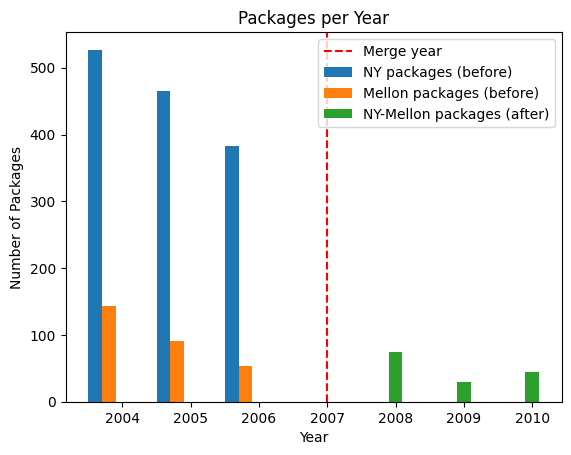

In [158]:
dates = NY_packages_3y_before_merger['DEALACTIVEDATE']
dates2 = Mellon_packages_3y_before_merger['DEALACTIVEDATE']
dates3=NY_packages_3y_after_merger['DEALACTIVEDATE']
dates4=Mellon_packages_3y_after_merger['DEALACTIVEDATE']


NY_packages_3y_before_merger['year'] = dates.dt.year.astype(int)
Mellon_packages_3y_before_merger['year'] = dates2.dt.year.astype(int)
NY_packages_3y_after_merger['year'] = dates3.dt.year.astype(int)
Mellon_packages_3y_after_merger['year'] = dates4.dt.year.astype(int)


# group by year and count the number of packages per year
yearly_counts_NY = NY_packages_3y_before_merger.groupby('year')['PACKAGEID'].count()
yearly_counts_mellon = Mellon_packages_3y_before_merger.groupby('year')['PACKAGEID'].count()
yearly_counts_A_NY = NY_packages_3y_after_merger.groupby('year')['PACKAGEID'].count()
yearly_counts_A_mellon = Mellon_packages_3y_after_merger.groupby('year')['PACKAGEID'].count()
#one for after merge
yearly_loan_amount_combined = yearly_counts_A_NY.add(yearly_counts_A_mellon, fill_value=0)

# plot the data as a line chart

bar_width = 0.2
plt.bar(yearly_counts_NY.index - 2*bar_width, yearly_counts_NY.values, width=bar_width, label='NY packages (before)')
plt.bar(yearly_counts_mellon.index - bar_width, yearly_counts_mellon.values, width=bar_width, label='Mellon packages (before)')

# plot the data as a bar chart with a single bar for the sum of NY and Mellon packages after the merger
plt.bar(yearly_loan_amount_combined.index, yearly_loan_amount_combined.values, width=bar_width, label='NY-Mellon packages (after)')

# add vertical line for merge year
plt.axvline(x=2007, color='r', linestyle='--', label='Merge year')

# add labels and title to the plot
plt.xlabel('Year')
plt.ylabel('Number of Packages')
plt.title('Packages per Year')
plt.legend()

# display the plot
plt.show()

**Facility Data for BNY Mellon**
---
**Finding facility data by year for banks**
we can use the below dataframes for facility analysis  **IMPORTANT**

    Facility amount: how big is the facility in terms of $ amount  

    Facility Start date

    Facility End date  

    What kind of facility it is: example, term loan  

    How long is it: 54 months  

    What’s the Primary Purpose: for working capital  

    Control variable “secure”; yes = 1 , no = 0   

In [159]:

facility_cleaned= pd.merge(facility_cleaned, package,how='left', on='PACKAGEID')
facility_cleaned['year'] = facility_cleaned['DEALACTIVEDATE'].dt.year.astype(int)


In [160]:

"""these are facility dataframes we can do analysis on it
our banks, split in year and lead, its ready to analize
"""
# ALL our facility dataframes - ALL YEARS
## Bank of New York
NY_all_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(NY_all_package_IDs)]
NY_lead_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(NY_lead_package_IDs)]
NY_nonlead_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(NY_nonlead_package_IDs)]
## Mellon Bank
mellon_all_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(mellon_all_package_IDs)]
mellon_lead_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(mellon_lead_package_IDs)]
mellon_nonlead_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(mellon_nonlead_package_IDs)]

# ALL our banks facility dataframes - 6 year interval
## Bank of New York
NY_6y_all_facility= facility_cleaned[facility_cleaned['PACKAGEID'].isin(NY_6y_all_package_IDs)]
NY_6y_lead_facility= facility_cleaned[facility_cleaned['PACKAGEID'].isin(NY_6y_lead_package_IDs)]
NY_6y_nonlead_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(NY_6y_nonlead_package_IDs)]
## Mellon Bank
mellon_6y_all_facility= facility_cleaned[facility_cleaned['PACKAGEID'].isin(mellon_6y_all_package_IDs)]
mellon_6y_lead_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(mellon_6y_lead_package_IDs)]
mellon_6y_nonlead_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(mellon_6y_nonlead_package_IDs)]

# ALL our banks facility dataframes - 3 years before
## Bank of New York
NY_3b_all_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(NY_3b_all_package_IDs)]
NY_3b_lead_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(NY_3b_lead_package_IDs)]
NY_3b_nonlead_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(NY_3b_nonlead_package_IDs)]
## Mellon Bank
mellon_3b_all_facility= facility_cleaned[facility_cleaned['PACKAGEID'].isin(mellon_3b_all_package_IDs)]
mellon_3b_lead_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(mellon_3b_lead_package_IDs)]
mellon_3b_nonlead_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(mellon_3b_nonlead_package_IDs)]

# ALL our banks facility dataframes - 3 years after
## Bank of New York
NY_3a_all_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(NY_3a_all_package_IDs)]
NY_3a_lead_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(NY_3a_lead_package_IDs)]
NY_3a_nonlead_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(NY_3a_nonlead_package_IDs)]
## Mellon Bank
mellon_3a_all_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(mellon_3a_all_package_IDs)]
mellon_3a_lead_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(mellon_3a_lead_package_IDs)]
mellon_3a_nonlead_facility = facility_cleaned[facility_cleaned['PACKAGEID'].isin(mellon_3a_nonlead_package_IDs)]
## Both -> combining both since after the merger its 1 entity thus facilities are with BNY Mellon
Both_3a_all_facility = pd.concat([NY_3a_all_facility, mellon_3a_all_facility], axis=0)
Both_3a_lead_facility = pd.concat([NY_3a_lead_facility, mellon_3a_lead_facility], axis=0)
Both_3a_nonlead_facility = pd.concat([NY_3a_nonlead_facility, mellon_3a_nonlead_facility], axis=0)


In [161]:
NY_facility_before=NY_3b_all_facility['FACILITYID'].nunique()
Mel_facility_before=mellon_3b_all_facility['FACILITYID'].nunique()

NY_facility_after=NY_3a_all_facility['FACILITYID'].nunique()
MEL_facility_after=mellon_3a_all_facility['FACILITYID'].nunique()

Facility_After=NY_facility_after+MEL_facility_after


Number_of_Facilities = {
    "NY": [NY_facility_before,Facility_After],
    "Mellon": [Mel_facility_before, Facility_After],
}
Number_of_Facilities = pd.DataFrame(Number_of_Facilities)
Number_of_Facilities = Number_of_Facilities.rename(index={0: "Before_Merge", 1: "After_Merge"})
Number_of_Facilities =Number_of_Facilities.transpose()
display(Number_of_Facilities)

,Before_Merge,After_Merge
NY,1858,180
Mellon,349,180


Int64Index([2004, 2005, 2006], dtype='int64', name='year')

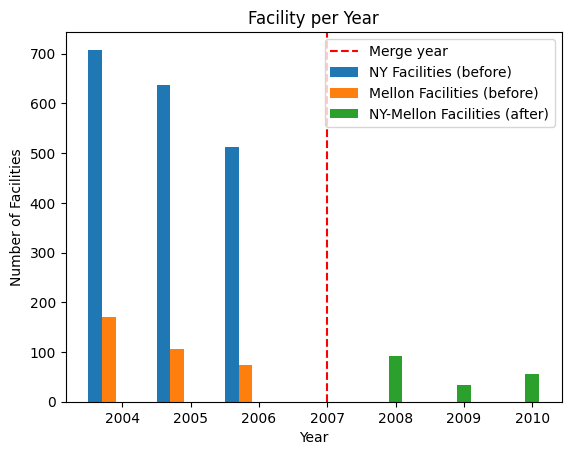

In [162]:
# group by year and count the number of packages per year for NY and Mellon separately, before and after the merger
yearly_counts_NYf_before = NY_3b_all_facility.groupby('year')['FACILITYID'].count()
yearly_counts_mellonf_before = mellon_3b_all_facility.groupby('year')['FACILITYID'].count()
yearly_counts_NYf_after = NY_3a_all_facility.groupby('year')['FACILITYID'].count()
yearly_counts_mellonf_after = mellon_3a_all_facility.groupby('year')['FACILITYID'].count()

# combine the counts for NY and Mellon packages after the merger
yearly_counts_NY_mellon_afterf = yearly_counts_NYf_after.add(yearly_counts_mellonf_after, fill_value=0)

# plot the data as a bar chart with multiple bars for each year before the merger
bar_width = 0.2
plt.bar(yearly_counts_NYf_before.index - 2*bar_width, yearly_counts_NYf_before.values, width=bar_width, label='NY Facilities (before)')
plt.bar(yearly_counts_mellonf_before.index - bar_width, yearly_counts_mellonf_before.values, width=bar_width, label='Mellon Facilities (before)')

# plot the data as a bar chart with a single bar for the sum of NY and Mellon packages after the merger
plt.bar(yearly_counts_NY_mellon_afterf.index, yearly_counts_NY_mellon_afterf.values, width=bar_width, label='NY-Mellon Facilities (after)')

# add vertical line for merge year
plt.axvline(x=2007, color='r', linestyle='--', label='Merge year')

# add labels and title to the plot
plt.xlabel('Year')
plt.ylabel('Number of Facilities')
plt.title('Facility per Year')
plt.legend()

# display the plot
yearly_counts_NYf_before.index

In [163]:
#Lead-NonLead
NYLEAD_facility_befor=NY_3b_lead_facility['FACILITYID'].nunique()
MelLEAD_facility_befor=mellon_3b_lead_facility['FACILITYID'].nunique()

NYLEAD_facility_after=NY_3a_lead_facility['FACILITYID'].nunique()
MELLEAD_facility_after=mellon_3a_lead_facility['FACILITYID'].nunique()

NYNLEAD_facility_befor=NY_3b_nonlead_facility['FACILITYID'].nunique()
MelNLEAD_facility_befor=mellon_3b_nonlead_facility['FACILITYID'].nunique()

NYNLEAD_facility_after=NY_3a_nonlead_facility['FACILITYID'].nunique()
MELNLEAD_facility_after=mellon_3a_nonlead_facility['FACILITYID'].nunique()

After_Facility_Lead=NYLEAD_facility_after+MELLEAD_facility_after
After_Facility_NLead=NYNLEAD_facility_after+MELNLEAD_facility_after

Number_of_Facility_LEAD = {
    "NY": ['lead_Arranger',NYLEAD_facility_befor,After_Facility_Lead],
    "NY_n": ['Non_Lead_Arranger',NYNLEAD_facility_befor,After_Facility_NLead],
    "Mellon": ['lead_Arranger',MelLEAD_facility_befor,After_Facility_Lead],
    "Mellon_n": ['Non_Lead_Arranger',MelNLEAD_facility_befor, After_Facility_NLead],
}
Number_of_Facility_LEAD = pd.DataFrame(Number_of_Facility_LEAD)
Number_of_Facility_LEAD = Number_of_Facility_LEAD.rename(index={0: 'Lead/NonLead', 1: "Before_Merge",2:'After_Merge'})
Number_of_Facility_LEAD =Number_of_Facility_LEAD.transpose()
display(Number_of_Facility_LEAD)

,Lead/NonLead,Before_Merge,After_Merge
NY,lead_Arranger,210,15
NY_n,Non_Lead_Arranger,1656,165
Mellon,lead_Arranger,0,15
Mellon_n,Non_Lead_Arranger,349,165


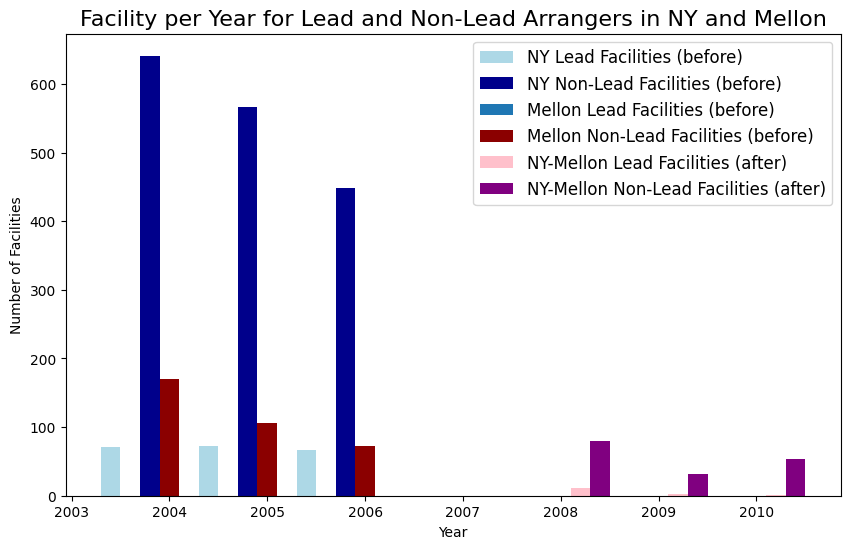

In [164]:
#all lead and non lead in one graph , but this was confusing , so I put 2 subtables in next code.

# group by year and lead/non-lead status for NY and Mellon separately, before and after the merger
NY_lead_counts_before = NY_3b_lead_facility.groupby('year')['FACILITYID'].count()
Mellon_lead_counts_before = mellon_3b_lead_facility.groupby('year')['FACILITYID'].count()
NY_nonlead_counts_before = NY_3b_nonlead_facility.groupby('year')['FACILITYID'].count()
Mellon_nonlead_counts_before = mellon_3b_nonlead_facility.groupby('year')['FACILITYID'].count()

NY_lead_counts_after = NY_3a_lead_facility.groupby('year')['FACILITYID'].count()
Mellon_lead_counts_after = mellon_3a_lead_facility.groupby('year')['FACILITYID'].count()
NY_nonlead_counts_after = NY_3a_nonlead_facility.groupby('year')['FACILITYID'].count()
Mellon_nonlead_counts_after = mellon_3a_nonlead_facility.groupby('year')['FACILITYID'].count()

# merge the counts for NY and Mellon facilities after the merger
NY_lead_mellon_lead_counts_after = NY_lead_counts_after.add(Mellon_lead_counts_after, fill_value=0)
NY_nonlead_mellon_nonlead_counts_after = NY_nonlead_counts_after.add(Mellon_nonlead_counts_after, fill_value=0)

# create a bar chart
bar_width = 0.2
plt.figure(figsize=(10,6)) # set the figure size
plt.bar(NY_lead_counts_before.index - 3*bar_width, NY_lead_counts_before.values, width=bar_width, color='lightblue', label='NY Lead Facilities (before)')
plt.bar(NY_nonlead_counts_before.index - bar_width, NY_nonlead_counts_before.values, width=bar_width, color='darkblue', label='NY Non-Lead Facilities (before)')

plt.bar(Mellon_lead_counts_before.index, Mellon_lead_counts_before.values, width=bar_width,label='Mellon Lead Facilities (before)', color='red')
plt.bar(Mellon_nonlead_counts_before.index, Mellon_nonlead_counts_before.values, width=bar_width, color='darkred', label='Mellon Non-Lead Facilities (before)')


plt.bar(NY_lead_mellon_lead_counts_after.index + bar_width, NY_lead_mellon_lead_counts_after.values, width=bar_width, color='pink', label='NY-Mellon Lead Facilities (after)')
plt.bar(NY_nonlead_mellon_nonlead_counts_after.index + 2*bar_width, NY_nonlead_mellon_nonlead_counts_after.values, width=bar_width, label='NY-Mellon Non-Lead Facilities (after)', color='purple')
# Add labels and title to the plot
plt.xlabel('Year')
plt.ylabel('Number of Facilities')
plt.title('Facility per Year for Lead and Non-Lead Arrangers in NY and Mellon', fontsize=16)

# set the font size of the legend
plt.legend(fontsize=12)

# Display the plot
plt.show()

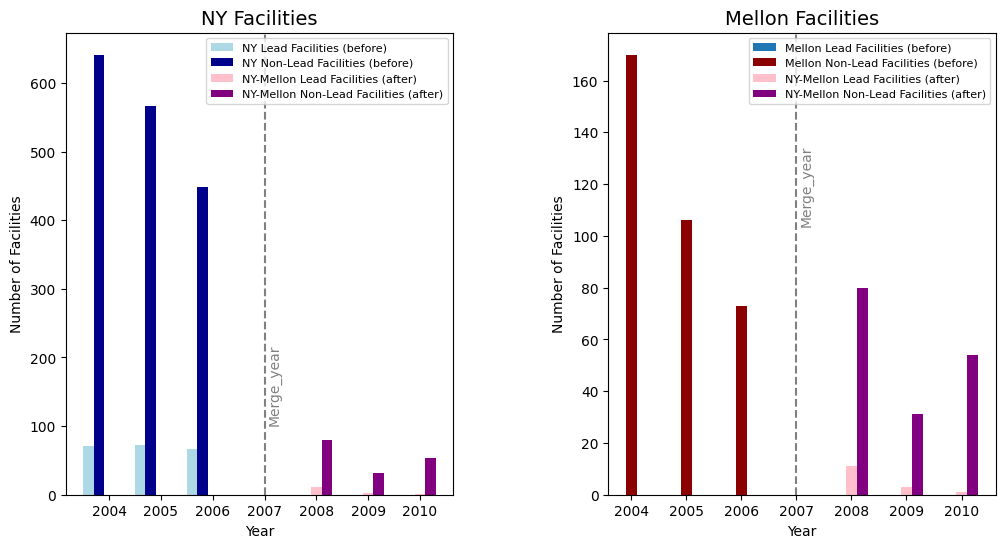

In [165]:
#2 different plot for Mellon and NY

# define the bar width
bar_width = 0.2

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# plot NY facilities on the first subplot
ax1.bar(NY_lead_counts_before.index - 2*bar_width, NY_lead_counts_before.values, width=bar_width, color='lightblue', label='NY Lead Facilities (before)')
ax1.bar(NY_nonlead_counts_before.index - bar_width, NY_nonlead_counts_before.values, width=bar_width, color='darkblue', label='NY Non-Lead Facilities (before)')
ax1.bar(NY_lead_mellon_lead_counts_after.index, NY_lead_mellon_lead_counts_after.values, width=bar_width, color='pink', label='NY-Mellon Lead Facilities (after)')
ax1.bar(NY_nonlead_mellon_nonlead_counts_after.index + bar_width, NY_nonlead_mellon_nonlead_counts_after.values, width=bar_width, label='NY-Mellon Non-Lead Facilities (after)', color='purple')
ax1.set_title('NY Facilities', fontsize=14)
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Facilities')
ax1.legend(fontsize=8)

# plot Mellon facilities on the second subplot
ax2.bar(Mellon_lead_counts_before.index - 2*bar_width, Mellon_lead_counts_before.values, width=bar_width,label='Mellon Lead Facilities (before)', color='red')
ax2.bar(Mellon_nonlead_counts_before.index, Mellon_nonlead_counts_before.values, width=bar_width, color='darkred', label='Mellon Non-Lead Facilities (before)')
ax2.bar(NY_lead_mellon_lead_counts_after.index, NY_lead_mellon_lead_counts_after.values, width=bar_width, color='pink', label='NY-Mellon Lead Facilities (after)')
ax2.bar(NY_nonlead_mellon_nonlead_counts_after.index + bar_width, NY_nonlead_mellon_nonlead_counts_after.values, width=bar_width, label='NY-Mellon Non-Lead Facilities (after)', color='purple')
ax2.set_title('Mellon Facilities', fontsize=14)
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Facilities')

ax2.legend(fontsize=8)

# add vertical line for merge year
merge_year = 2007
ax1.axvline(x=merge_year, color='gray', linestyle='--')
ax1.text(merge_year+0.05, 105, 'Merge_year', rotation=90, fontsize=10, color='gray')
ax2.axvline(x=merge_year, color='gray', linestyle='--')
ax2.text(merge_year+0.05, 105, 'Merge_year', rotation=90, fontsize=10, color='gray')

# adjust the x-axis tick labels to show integer years
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax2.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4)

# show the plot
plt.show()

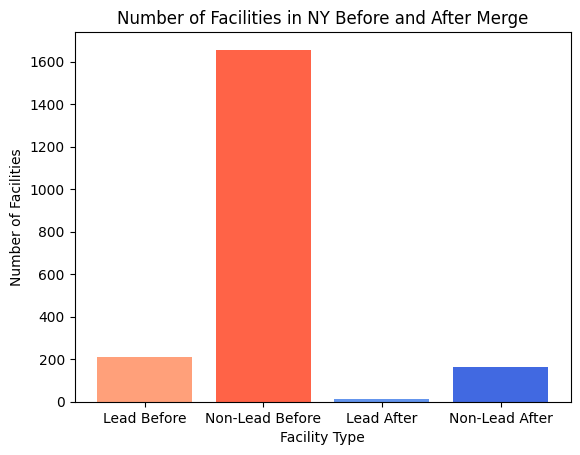

In [166]:
#these are with out considering grouping by years:
# Extract the data for plotting
lead_before = Number_of_Facility_LEAD.loc['NY', 'Before_Merge']
lead_after = Number_of_Facility_LEAD.loc['NY', 'After_Merge']
non_lead_before = Number_of_Facility_LEAD.loc['NY_n', 'Before_Merge']
non_lead_after = Number_of_Facility_LEAD.loc['NY_n', 'After_Merge']

# Set up the bar chart
labels = ['Lead Before','Non-Lead Before', 'Lead After',  'Non-Lead After']
values = [lead_before, non_lead_before,lead_after,  non_lead_after]
colors = ['#FFA07A', '#FF6347', '#6495ED', '#4169E1']

plt.bar(labels, values, color=colors)
plt.title('Number of Facilities in NY Before and After Merge')
plt.xlabel('Facility Type')
plt.ylabel('Number of Facilities')
plt.show()

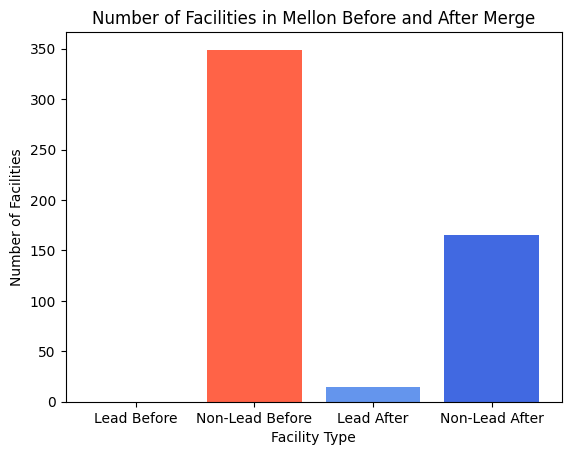

In [167]:
# Extract the data for plotting
lead_before = Number_of_Facility_LEAD.loc['Mellon', 'Before_Merge']
lead_after = Number_of_Facility_LEAD.loc['Mellon', 'After_Merge']
non_lead_before = Number_of_Facility_LEAD.loc['Mellon_n', 'Before_Merge']
non_lead_after = Number_of_Facility_LEAD.loc['Mellon_n', 'After_Merge']

# Set up the bar chart
labels = ['Lead Before','Non-Lead Before', 'Lead After',  'Non-Lead After']
values = [lead_before, non_lead_before,lead_after,  non_lead_after]
colors = ['#FFA07A', '#FF6347', '#6495ED', '#4169E1']

plt.bar(labels, values, color=colors)
plt.title('Number of Facilities in Mellon Before and After Merge')
plt.xlabel('Facility Type')
plt.ylabel('Number of Facilities')
plt.show()

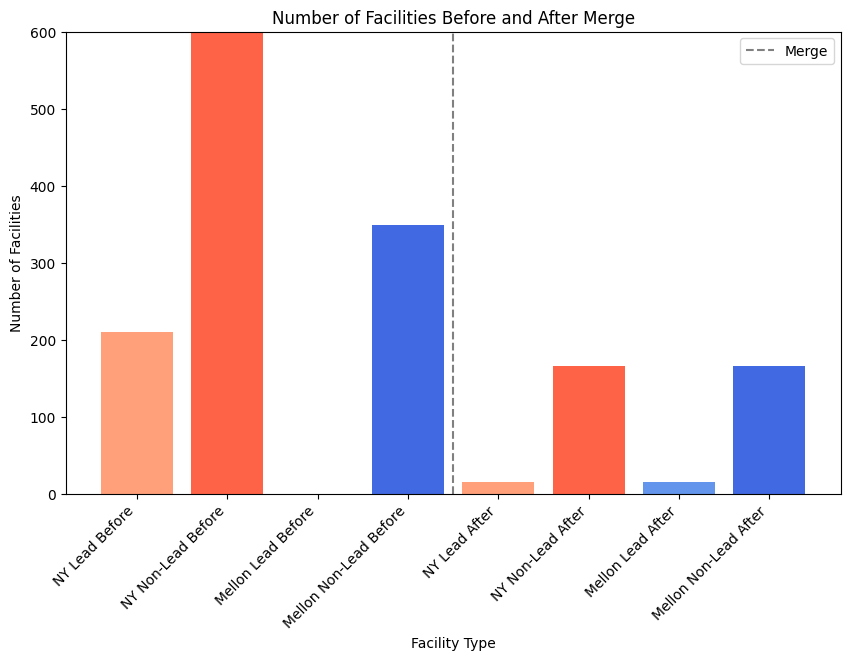

In [168]:

# Extract the data for plotting
ny_lead_before = Number_of_Facility_LEAD.loc['NY', 'Before_Merge']
ny_lead_after = Number_of_Facility_LEAD.loc['NY', 'After_Merge']
ny_non_lead_before = Number_of_Facility_LEAD.loc['NY_n', 'Before_Merge']
ny_non_lead_after = Number_of_Facility_LEAD.loc['NY_n', 'After_Merge']

mellon_lead_before = Number_of_Facility_LEAD.loc['Mellon', 'Before_Merge']
mellon_lead_after = Number_of_Facility_LEAD.loc['Mellon', 'After_Merge']
mellon_non_lead_before = Number_of_Facility_LEAD.loc['Mellon_n', 'Before_Merge']
mellon_non_lead_after = Number_of_Facility_LEAD.loc['Mellon_n', 'After_Merge']

# Set up the bar chart
labels = ['NY Lead Before','NY Non-Lead Before', 'Mellon Lead Before', 'Mellon Non-Lead Before', 'NY Lead After', 'NY Non-Lead After', 'Mellon Lead After', 'Mellon Non-Lead After']
values = [ny_lead_before, ny_non_lead_before, mellon_lead_before, mellon_non_lead_before, ny_lead_after, ny_non_lead_after, mellon_lead_after, mellon_non_lead_after]

colors = ['#FFA07A', '#FF6347', '#6495ED', '#4169E1', '#FFA07A', '#FF6347', '#6495ED', '#4169E1']

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=colors)
plt.title('Number of Facilities Before and After Merge')
plt.xlabel('Facility Type')
plt.ylabel('Number of Facilities')
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 600])
plt.axvline(x=3.5, color='grey', linestyle='--', label='Merge')
plt.legend()
plt.show()

**Public Borrowers**
---
Finding out out which of our facilities are public, and merging it onto the comps database so we can do more analysis

 There’s facility ID & gvkey a link = public  
    No link = private  
Thus now we can see, before and after, if they are lending more to public or private borrowers  

we need this to see how risky the borrower is

In [169]:
dealscan_compustat_linktable['facstartdate'] = pd.to_datetime(dealscan_compustat_linktable['facstartdate'], format='%Y%m%d')
dealscan_compustat_linktable['facstartdate'] = dealscan_compustat_linktable['facstartdate'].dt.year


In [170]:

# ALL our banks facility dataframes IDs - 3 years before
## Bank of New York
NY_3b_all_facility_IDs = NY_3b_all_facility["FACILITYID"].tolist()
NY_3b_lead_facility_IDs = NY_3b_lead_facility["FACILITYID"].tolist()
NY_3b_nonlead_facility_IDs = NY_3b_nonlead_facility["FACILITYID"].tolist()
## Mellon Bank
mellon_3b_all_facility_IDs = mellon_3b_all_facility["FACILITYID"].tolist()
mellon_3b_lead_facility_IDs = mellon_3b_lead_facility["FACILITYID"].tolist()
mellon_3b_nonlead_facility_IDs = mellon_3b_nonlead_facility["FACILITYID"].tolist()
## Both IDs after -> BNY Mellon after merger
Both_3a_all_facility_IDs = Both_3a_all_facility["FACILITYID"].tolist()
Both_3a_lead_facility_IDs = Both_3a_lead_facility["FACILITYID"].tolist()
Both_3a_nonlead_facility_IDs = Both_3a_nonlead_facility["FACILITYID"].tolist()

# Linking public firms with Link Table
## Bank of New York


link_NY_3b_all_facility = dealscan_compustat_linktable[dealscan_compustat_linktable['facid'].isin(NY_3b_all_facility_IDs)]
link_NY_3b_lead_facility = dealscan_compustat_linktable[dealscan_compustat_linktable['facid'].isin(NY_3b_lead_facility_IDs)]
link_NY_3b_nonlead_facility = dealscan_compustat_linktable[dealscan_compustat_linktable['facid'].isin(NY_3b_nonlead_facility_IDs)]
## Mellon Bank
link_mellon_3b_all_facility = dealscan_compustat_linktable[dealscan_compustat_linktable['facid'].isin(mellon_3b_all_facility_IDs)]
link_mellon_3b_lead_facility = dealscan_compustat_linktable[dealscan_compustat_linktable['facid'].isin(mellon_3b_lead_facility_IDs)]
link_mellon_3b_nonlead_facility = dealscan_compustat_linktable[dealscan_compustat_linktable['facid'].isin(mellon_3b_nonlead_facility_IDs)]
## Both, after merger BNY Mellon
link_Both_3a_all_facility = dealscan_compustat_linktable[dealscan_compustat_linktable['facid'].isin(Both_3a_all_facility_IDs)]
link_Both_3a_lead_facility = dealscan_compustat_linktable[dealscan_compustat_linktable['facid'].isin(Both_3a_lead_facility_IDs)]
link_Both_3a_nonlead_facility = dealscan_compustat_linktable[dealscan_compustat_linktable['facid'].isin(Both_3a_nonlead_facility_IDs)]

# Retreiving a list of GVKEY associated with our pannks
## Bank of New York
gvkey_NY_3b_all_facility = link_NY_3b_all_facility["gvkey"].tolist()
gvkey_NY_3b_lead_facility = link_NY_3b_lead_facility["gvkey"].tolist()
gvkey_NY_3b_nonlead_facility = link_NY_3b_nonlead_facility["gvkey"].tolist()
## Mellon Bank
gvkey_mellon_3b_all_facility = link_mellon_3b_all_facility["gvkey"].tolist()
gvkey_mellon_3b_lead_facility = link_mellon_3b_lead_facility["gvkey"].tolist()
gvkey_mellon_3b_nonlead_facility = link_mellon_3b_nonlead_facility["gvkey"].tolist()
## Both IDs after -> BNY Mellon after merger
gvkey_Both_3a_all_facility= link_Both_3a_all_facility["gvkey"].tolist()
gvvkey_Both_3a_lead_facility = link_Both_3a_lead_facility["gvkey"].tolist()
gvkey_Both_3a_nonlead_facility = link_Both_3a_nonlead_facility["gvkey"].tolist()

# Retreiving the respected years
# Retreiving a list of GVKEY associated with our pannks
## Bank of New York
facstartdate_NY_3b_all_facility = link_NY_3b_all_facility["facstartdate"].tolist()
facstartdate_NY_3b_lead_facility = link_NY_3b_lead_facility["facstartdate"].tolist()
facstartdate_NY_3b_nonlead_facility = link_NY_3b_nonlead_facility["facstartdate"].tolist()
## Mellon Bank
facstartdate_mellon_3b_all_facility = link_mellon_3b_all_facility["facstartdate"].tolist()
facstartdate_mellon_3b_lead_facility = link_mellon_3b_lead_facility["facstartdate"].tolist()
facstartdate_mellon_3b_nonlead_facility = link_mellon_3b_nonlead_facility["facstartdate"].tolist()
## Both IDs after -> BNY Mellon after merger
facstartdate_Both_3a_all_facility = link_Both_3a_all_facility["facstartdate"].tolist()
facstartdate_Both_3a_lead_facility = link_Both_3a_lead_facility["facstartdate"].tolist()
facstartdate_Both_3a_nonlead_facility = link_Both_3a_nonlead_facility["facstartdate"].tolist()

# Retreiving Facid
# Retreiving a list of GVKEY associated with our pannks
## Bank of New York
facid_NY_3b_all_facility = link_NY_3b_all_facility["facid"].tolist()
facid__NY_3b_lead_facility = link_NY_3b_lead_facility["facid"].tolist()
facid__NY_3b_nonlead_facility = link_NY_3b_nonlead_facility["facid"].tolist()
## Mellon Bank
facid__mellon_3b_all_facility = link_mellon_3b_all_facility["facid"].tolist()
facid__mellon_3b_lead_facility = link_mellon_3b_lead_facility["facid"].tolist()
facid__mellon_3b_nonlead_facility = link_mellon_3b_nonlead_facility["facid"].tolist()
## Both IDs after -> BNY Mellon after merger
facid__Both_3a_all_facility = link_Both_3a_all_facility["facid"].tolist()
facid__Both_3a_lead_facility = link_Both_3a_lead_facility["facid"].tolist()
facid__Both_3a_nonlead_facility = link_Both_3a_nonlead_facility["facid"].tolist()

# Dataframes of GVKEY plus Facility start date, now we can merge with compustate
# bny
gvkey_facstartdate_NY_3b_all = pd.DataFrame({'GVKEY': gvkey_NY_3b_all_facility, 'FYEAR': facstartdate_NY_3b_all_facility, 'FACILITYID': facid_NY_3b_all_facility})
gvkey_facstartdate_NY_3b_lead_facility = pd.DataFrame({'GVKEY': gvkey_NY_3b_lead_facility, 'FYEAR': facstartdate_NY_3b_lead_facility, 'FACILITYID': facid__NY_3b_lead_facility})
gvkey_facstartdate_NY_3b_nonlead_facility = pd.DataFrame({'GVKEY': gvkey_NY_3b_nonlead_facility, 'FYEAR': facstartdate_NY_3b_nonlead_facility, 'FACILITYID': facid__NY_3b_nonlead_facility})
# mellon bank
gvkey_facstartdate_mellon_3b_all = pd.DataFrame({'GVKEY': gvkey_mellon_3b_all_facility, 'FYEAR': facstartdate_mellon_3b_all_facility, 'FACILITYID': facid__mellon_3b_all_facility})
gvkey_facstartdate_mellon_3b_lead = pd.DataFrame({'GVKEY': gvkey_mellon_3b_lead_facility, 'FYEAR': facstartdate_mellon_3b_lead_facility, 'FACILITYID': facid__mellon_3b_lead_facility})
gvkey_facstartdate_mellon_3b_nonlead= pd.DataFrame({'GVKEY': gvkey_mellon_3b_nonlead_facility, 'FYEAR': facstartdate_mellon_3b_nonlead_facility, 'FACILITYID': facid__mellon_3b_nonlead_facility})
# both
gvkey_facstartdate_Both_3a_all = pd.DataFrame({'GVKEY': gvkey_Both_3a_all_facility, 'FYEAR': facstartdate_Both_3a_all_facility, 'FACILITYID': facid__Both_3a_all_facility})
gvkey_facstartdate_Both_3a_lead = pd.DataFrame({'GVKEY': gvvkey_Both_3a_lead_facility, 'FYEAR': facstartdate_Both_3a_lead_facility, 'FACILITYID': facid__Both_3a_lead_facility})
gvkey_facstartdate_Both_3a_nonlead = pd.DataFrame({'GVKEY': gvkey_Both_3a_nonlead_facility, 'FYEAR': facstartdate_Both_3a_nonlead_facility, 'FACILITYID': facid__Both_3a_nonlead_facility})

""" we need to look at borrowers information, 1 year lagged.
Thus I'm reducing the Facility start year by 1
"""
# Lagged FYEAR, so we have the borrower inbformation the bank was analyzing to give out the loan
## Bank of New York
gvkey_facstartdate_NY_3b_all["FYEAR"] = gvkey_facstartdate_NY_3b_all["FYEAR"] -1
gvkey_facstartdate_NY_3b_lead_facility["FYEAR"] = gvkey_facstartdate_NY_3b_lead_facility["FYEAR"] -1
gvkey_facstartdate_NY_3b_nonlead_facility["FYEAR"] = gvkey_facstartdate_NY_3b_nonlead_facility["FYEAR"] -1
## Mellon Bank
gvkey_facstartdate_mellon_3b_all["FYEAR"] = gvkey_facstartdate_mellon_3b_all["FYEAR"] -1
gvkey_facstartdate_mellon_3b_lead["FYEAR"] = gvkey_facstartdate_mellon_3b_lead["FYEAR"] -1
gvkey_facstartdate_mellon_3b_nonlead["FYEAR"] = gvkey_facstartdate_mellon_3b_nonlead["FYEAR"] -1
# Both
gvkey_facstartdate_Both_3a_all["FYEAR"] = gvkey_facstartdate_Both_3a_all["FYEAR"] -1
gvkey_facstartdate_Both_3a_lead["FYEAR"] = gvkey_facstartdate_Both_3a_lead["FYEAR"] -1
gvkey_facstartdate_Both_3a_nonlead["FYEAR"] = gvkey_facstartdate_Both_3a_nonlead["FYEAR"] -1

# # Compustat data on our borrowers
# ## Bank of New York
public_borrower_NY_3b_all = pd.merge(comp, gvkey_facstartdate_NY_3b_all, on=['GVKEY', 'FYEAR'], how='inner')
public_borrower_NY_3b_lead = pd.merge(comp, gvkey_facstartdate_NY_3b_lead_facility, on=['GVKEY', 'FYEAR'], how='inner')
public_borrower_NY_3b_nonlead = pd.merge(comp, gvkey_facstartdate_NY_3b_nonlead_facility, on=['GVKEY', 'FYEAR'], how='inner')
## Mellon Bank
public_borrower_mellon_3b_all = pd.merge(comp, gvkey_facstartdate_mellon_3b_all, on=['GVKEY', 'FYEAR'], how='inner')
public_borrower_mellon_3b_lead = pd.merge(comp, gvkey_facstartdate_mellon_3b_lead, on=['GVKEY', 'FYEAR'], how='inner')
public_borrower_mellon_3b_nonlead = pd.merge(comp, gvkey_facstartdate_mellon_3b_nonlead, on=['GVKEY', 'FYEAR'], how='inner')
# Both
public_borrower_Both_3a_all = pd.merge(comp, gvkey_facstartdate_Both_3a_all, on=['GVKEY', 'FYEAR'], how='inner')
public_borrower_Both_3a_lead = pd.merge(comp, gvkey_facstartdate_Both_3a_lead, on=['GVKEY', 'FYEAR'], how='inner')
public_borrower_Both_3a_nonlead = pd.merge(comp, gvkey_facstartdate_Both_3a_nonlead, on=['GVKEY', 'FYEAR'], how='inner')
""" To be noted, there is some row loss after the Merge onto compustat. I'm unsure why.

Shouldn't hurt our results too much, when we report the amount of public borrowers, maybe best to
report the lenght of the gvkey_facstartdate df, since some off compustat get lost.

However overall, the borrower info can still be analyzed. This, is a note to maybe ask the prof.
"""

" To be noted, there is some row loss after the Merge onto compustat. I'm unsure why.\n\nShouldn't hurt our results too much, when we report the amount of public borrowers, maybe best to\nreport the lenght of the gvkey_facstartdate df, since some off compustat get lost.\n\nHowever overall, the borrower info can still be analyzed. This, is a note to maybe ask the prof.\n"

**Public Borrowers Analsyis**
---
lets analyse the public borrowers here. Such as their riskyness.


**Variable analyis of borrowers and regressions**

In [171]:
# Grouping pricing based off facid
pricing_grouped  = pricing.groupby('FACILITYID').first()
pricing_grouped = pricing_grouped.dropna()
pricing_grouped = pricing_grouped[pricing_grouped['BASERATE'] == 'LIBOR']

# Adding pricing grouped to our publicn borrowers
## Bank of New York
public_borrower_NY_3b_all_merged = public_borrower_NY_3b_all.merge(pricing_grouped, how= "left", left_on='FACILITYID', right_on='FACILITYID')
public_borrower_NY_3b_lead_merged = public_borrower_NY_3b_lead.merge(pricing_grouped, how= "left", left_on='FACILITYID', right_on='FACILITYID')
public_borrower_NY_3b_nonlead_merged = public_borrower_NY_3b_nonlead.merge(pricing_grouped, how= "left", left_on='FACILITYID', right_on='FACILITYID')
## Mellon Bank
public_borrower_mellon_3b_all_merged = public_borrower_mellon_3b_all.merge(pricing_grouped, how= "left", left_on='FACILITYID', right_on='FACILITYID')
public_borrower_mellon_3b_lead_merged = public_borrower_mellon_3b_lead.merge(pricing_grouped, how= "left", left_on='FACILITYID', right_on='FACILITYID')
public_borrower_mellon_3b_nonlead_merged = public_borrower_mellon_3b_nonlead.merge(pricing_grouped, how= "left", left_on='FACILITYID', right_on='FACILITYID')
# Both
public_borrower_Both_3a_all_merged = public_borrower_Both_3a_all.merge(pricing_grouped, how= "left", left_on='FACILITYID', right_on='FACILITYID')
public_borrower_Both_3a_lead_merged = public_borrower_Both_3a_lead.merge(pricing_grouped, how= "left", left_on='FACILITYID', right_on='FACILITYID')
public_borrower_Both_3a_nonlead_merged = public_borrower_Both_3a_nonlead.merge(pricing_grouped, how= "left", left_on='FACILITYID', right_on='FACILITYID')

In [172]:
# variable creation



# variable analysis


**Descriptive analysis of borrowers**


In [173]:
# number of public borrowers
number_public_borrower_NY_3b_all=public_borrower_NY_3b_all['GVKEY'].nunique()
number_public_borrower_NY_3b_lead=public_borrower_NY_3b_lead['GVKEY'].nunique()
number_public_borrower_NY_3b_nonlead=public_borrower_NY_3b_nonlead['GVKEY'].nunique()
## Mellon Bank
number_public_borrower_mellon_3b_all=public_borrower_mellon_3b_all['GVKEY'].nunique()
number_public_borrower_mellon_3b_lead=public_borrower_mellon_3b_lead['GVKEY'].nunique()
number_public_borrower_mellon_3b_nonlead=public_borrower_mellon_3b_nonlead['GVKEY'].nunique()
# Both
number_public_borrower_Both_3a_all=public_borrower_Both_3a_all['GVKEY'].nunique()
number_public_borrower_Both_3a_lead=public_borrower_Both_3a_lead['GVKEY'].nunique()
number_public_borrower_Both_3a_nonlead=public_borrower_Both_3a_nonlead['GVKEY'].nunique()


Number_of_PUBLIC_LEAD = {
    "NY": ['lead_Arranger',number_public_borrower_NY_3b_lead,number_public_borrower_Both_3a_lead],
    "NY_n": ['Non_Lead_Arranger',number_public_borrower_NY_3b_nonlead,number_public_borrower_Both_3a_nonlead],
    "Mellon": ['lead_Arranger',number_public_borrower_mellon_3b_lead,number_public_borrower_Both_3a_lead],
    "Mellon_n": ['Non_Lead_Arranger',number_public_borrower_mellon_3b_nonlead, number_public_borrower_Both_3a_nonlead],
}
Number_of_PUBLIC_LEAD = pd.DataFrame(Number_of_PUBLIC_LEAD)
Number_of_PUBLIC_LEAD = Number_of_PUBLIC_LEAD.rename(index={0: 'Lead/NonLead', 1: "Before_Merge",2:'After_Merge'})
Number_of_PUBLIC_LEAD =Number_of_PUBLIC_LEAD.transpose()
display(Number_of_PUBLIC_LEAD)

,Lead/NonLead,Before_Merge,After_Merge
NY,lead_Arranger,43,4
NY_n,Non_Lead_Arranger,533,69
Mellon,lead_Arranger,0,4
Mellon_n,Non_Lead_Arranger,134,69


In [174]:
# Number of private borrowers
#NY
number_private_borrower_NY_3b_lead=NYLEAD_facility_befor-number_public_borrower_NY_3b_lead
number_private_borrower_NY_3b_nonlead=NYNLEAD_facility_befor-number_public_borrower_NY_3b_nonlead
## Mellon Bank
number_private_borrower_mellon_3b_lead=MelLEAD_facility_befor-number_public_borrower_mellon_3b_lead
number_private_borrower_mellon_3b_nonlead=MelNLEAD_facility_befor-number_public_borrower_mellon_3b_nonlead
# Both

number_private_borrower_Both_3a_lead=After_Facility_Lead-number_public_borrower_Both_3a_lead
number_private_borrower_Both_3a_nonlead=After_Facility_NLead-number_public_borrower_Both_3a_nonlead

Number_of_Private_LEAD = {
    "NY": ['lead_Arranger',number_private_borrower_NY_3b_lead,number_private_borrower_Both_3a_lead],
    "NY_n": ['Non_Lead_Arranger',number_private_borrower_NY_3b_nonlead,number_private_borrower_Both_3a_nonlead],
    "Mellon": ['lead_Arranger',number_private_borrower_mellon_3b_lead,number_private_borrower_Both_3a_lead],
    "Mellon_n": ['Non_Lead_Arranger',number_private_borrower_mellon_3b_nonlead, number_private_borrower_Both_3a_nonlead],
}
Number_of_Private_LEAD = pd.DataFrame(Number_of_Private_LEAD)
Number_of_Private_LEAD = Number_of_Private_LEAD.rename(index={0: 'Lead/NonLead', 1: "Before_Merge",2:'After_Merge'})
Number_of_Private_LEAD =Number_of_Private_LEAD.transpose()
display(Number_of_Private_LEAD)

,Lead/NonLead,Before_Merge,After_Merge
NY,lead_Arranger,167,11
NY_n,Non_Lead_Arranger,1123,96
Mellon,lead_Arranger,0,11
Mellon_n,Non_Lead_Arranger,215,96


**Voting and ISS Rec analysis**
---

"""
Iddentify the relevant meeting in the given time [2004-6] ...2008-10

look at what happens in these .........

    LOOK AT MEETING DATA,

    sh sponsore or manager

    look at % votedd against, that tells us sh actvivism... this is only manageer activist

    sh proposoal we can se ehow many past, do they fail by alot or close call

thats enough

sh more or less invovelved post merger

In [175]:
# Our 2 dataframes with voting data

voting_results = pd.read_csv('voting_results.csv', encoding='ISO-8859-1')
iss_recommendations = pd.read_csv('iss_recommendations.csv', encoding='ISO-8859-1')
# merging the 2 on MeetingID, ISSAgendaID, itenonAgendaID .
voting_iss_rec = pd.merge(voting_results, iss_recommendations[['MeetingID', 'ISSAgendaItemID', 'itemOnAgendaID', 'ISSrec']], on=['MeetingID', 'ISSAgendaItemID', 'itemOnAgendaID'], how='left')

# Compressing the Bank names, since they have multiple versions
""""
Post-merger:
    BNY Mellon

Pre-merger:
    Mellon Bank: Mellon Financial Corp.
    Bank of New York: BNY Mellon -> because bny name got updated after merger
"""
banks_to_replace = ['The Bank of New York Mellon Corporation',
                    'THE BANK OF NEW YORK MELLON CORPORATION',
                    'The Bank of New York Mellon Corp.',
                    'BNY Mellon Strategic Municipals, Inc.',
                    'BNY Mellon Investment Funds IV, Inc.',
                    'BNY Mellon Municipal Income, Inc.',
                    'BNY Mellon Strategic Municipal Bond Fund, Inc.',
                    'BNY Mellon High Yield Strategies Fund',
                    'BNY Mellon Funds Trust',
                    'BNY Mellon Municipal Bond Infrastructure Fund, Inc.',
                    'BNY Mellon Alcentra Global Credit Income 2024 Target Term Fd I',
                    'Bny Mellon Growth & Income Fund Inc.']

voting_iss_rec['Name'] = voting_iss_rec['Name'].replace(banks_to_replace, 'BNY Mellon')

# MeetingDate
voting_iss_rec['MeetingDate'] = pd.to_datetime(voting_iss_rec['MeetingDate'], format='%Y%m%d')
before_start_date = pd.to_datetime('2004-01-01')
before_end_date = pd.to_datetime('2006-12-31')
# merger 2007, bench mark year
after_start_date = pd.to_datetime('2008-01-01')
after_end_date = pd.to_datetime('2010-12-31')

# Splitting the voting results by year
## Before [2004 - 2006]
voting_iss_rec_before = voting_iss_rec[(voting_iss_rec['MeetingDate'] >= before_start_date) & (voting_iss_rec['MeetingDate'] <= before_end_date)]
## After [2008-2010]
voting_iss_rec_after = voting_iss_rec[(voting_iss_rec['MeetingDate'] >= after_start_date) & (voting_iss_rec['MeetingDate'] <= after_end_date)]

# Selecting voting results that had our banks
bank_of_ny_voting_before = voting_iss_rec_before.loc[voting_iss_rec_before["Name"] == "BNY Mellon"]
mellon_bank_voting_before = voting_iss_rec_before.loc[voting_iss_rec_before["Name"] == "Mellon Financial Corp."]
BNY_mellon_voting_after =  voting_iss_rec_after.loc[voting_iss_rec_after["Name"] == "BNY Mellon"]

In [176]:
# Voting Analysis
bank_of_ny_voting_before
mellon_bank_voting_before
BNY_mellon_voting_after

"""proposal sponsor analysis, management versus shareholder"""

# Proposal sponsor Management or Shareholder
## Bank of New York before merger
management_count_ny_before = bank_of_ny_voting_before["sponsor"].value_counts()["Management"]
management_likelyhood_ny_before = likelihood_function(bank_of_ny_voting_before, "sponsor","Management" )
shareholder__count_ny_before = bank_of_ny_voting_before["sponsor"].value_counts()["Shareholder"]
shareholder_likelyhood_ny_before = likelihood_function(bank_of_ny_voting_before, "sponsor","Shareholder" )

## Mellon Bank before merger
management_count_mellon_before = mellon_bank_voting_before["sponsor"].value_counts()["Management"]
management_likelyhood_mellon_before = likelihood_function(mellon_bank_voting_before, "sponsor","Management" )
shareholder__count_mellon_before = mellon_bank_voting_before["sponsor"].value_counts()["Shareholder"]
shareholder_likelyhood_mellon_before = likelihood_function(mellon_bank_voting_before, "sponsor","Shareholder" )

## BNY Mellon after merger
management_count_BNY_Mellon_after = BNY_mellon_voting_after["sponsor"].value_counts()["Management"]
management_likelyhood_BNY_Mellon_after = likelihood_function(BNY_mellon_voting_after, "sponsor","Management" )
shareholder__count_BNY_Mellon_after = BNY_mellon_voting_after["sponsor"].value_counts()["Shareholder"]
shareholder_likelyhood_BNY_Mellon_after = likelihood_function(BNY_mellon_voting_after, "sponsor","Shareholder" )

# Sponsor t-tests
timeseries_management_sponsor_t_test = T_test_dummies(bank_of_ny_voting_before,BNY_mellon_voting_after, "sponsor","Management")
timeseries_shareholder_sponsor_t_test = T_test_dummies(bank_of_ny_voting_before,BNY_mellon_voting_after, "sponsor","Shareholder")
cross_section_management_sponsor_t_test = T_test_dummies(mellon_bank_voting_before,BNY_mellon_voting_after, "sponsor","Management")
cross_section_shareholder_sponsor_t_test = T_test_dummies(mellon_bank_voting_before,BNY_mellon_voting_after, "sponsor","Shareholder")


# time series comparason of management and shareholder sponsor
print(f"Time-series comparason of management and shareholder sponsor")
sponsor_timeseries_data = {
    "BNY Total Count": [management_count_ny_before, shareholder__count_ny_before],
    "BNY Likelyhood": [management_likelyhood_ny_before, shareholder_likelyhood_ny_before],
    "BNY Mellon Total Count": [management_count_BNY_Mellon_after, shareholder__count_BNY_Mellon_after],
    "BNY Mellon Likelyhood": [management_likelyhood_BNY_Mellon_after, shareholder_likelyhood_BNY_Mellon_after],
    "t-test": [timeseries_management_sponsor_t_test[0], timeseries_shareholder_sponsor_t_test[0]],
    "p-value": [timeseries_management_sponsor_t_test[1], timeseries_shareholder_sponsor_t_test[1]],
}
Sponsor_table_timeseries = pd.DataFrame(sponsor_timeseries_data, index=["Management", "Shareholder"])
display(Sponsor_table_timeseries)

# cross sectional comparason of management and shareholder sponsors
print(f"cross-section sponsors comparasing Mellon Bank and BNY mellon")
sponsor_cross_section_data = {
    "Mellon Total Count": [management_count_mellon_before, shareholder__count_mellon_before],
    "Mellon Likelyhood": [management_likelyhood_mellon_before, shareholder_likelyhood_mellon_before],
    "BNY Mellon Total Count": [management_count_BNY_Mellon_after, shareholder__count_BNY_Mellon_after],
    "BNY Mellon Likelyhood": [management_likelyhood_BNY_Mellon_after, shareholder_likelyhood_BNY_Mellon_after],
    "t-test": [cross_section_management_sponsor_t_test[0], cross_section_shareholder_sponsor_t_test[0]],
    "p-value": [cross_section_management_sponsor_t_test[1], cross_section_shareholder_sponsor_t_test[1]],
}
Sponsor_table_cross_section = pd.DataFrame(sponsor_cross_section_data, index=["Management", "Shareholder"])
display(Sponsor_table_cross_section)


Time-series comparason of management and shareholder sponsor


,BNY Total Count,BNY Likelyhood,BNY Mellon Total Count,BNY Mellon Likelyhood,t-test,p-value
Management,46,0.851852,56,0.888889,-0.593157,0.554241
Shareholder,8,0.148148,7,0.111111,0.593157,0.554241


cross-section sponsors comparasing Mellon Bank and BNY mellon


,Mellon Total Count,Mellon Likelyhood,BNY Mellon Total Count,BNY Mellon Likelyhood,t-test,p-value
Management,20,0.952381,56,0.888889,0.851859,0.396773
Shareholder,1,0.047619,7,0.111111,-0.851859,0.396773


In [177]:
""" Analyzing agenda descriptions"""
# Agenda description, "what the meeting is for, to elect director, etc"
ny_agenda_before = bank_of_ny_voting_before["AgendaGeneralDesc"].value_counts()
ny_agenda_before = ny_agenda_before.head(5)
mellon_agenda_before = mellon_bank_voting_before["AgendaGeneralDesc"].value_counts()
mellon_agenda_before = mellon_agenda_before.head(5)
bny_mellon_agenda_after = BNY_mellon_voting_after["AgendaGeneralDesc"].value_counts()
bny_mellon_agenda_after = bny_mellon_agenda_after.head(5)

"""Agenda description analyiss"""
# Agenda description tables
## Bank of New York agenda tale before merger
ny_agenda_table = pd.DataFrame({
    "Agenda Description": ny_agenda_before.index,
    "BNY Votes": ny_agenda_before.values,
    "BNY Likelyhood": ny_agenda_before.values / bank_of_ny_voting_before["AgendaGeneralDesc"].count()
})
print("Bank of New York's Agenda Before Merger")
display(ny_agenda_table.head(5))


## Mellon Bank before merger
mellon_angenda_table = pd.DataFrame({
    "Agenda Description": mellon_agenda_before.index,
    "Mellon Votes": mellon_agenda_before.values,
    "BNY Likelyhood": mellon_agenda_before.values / mellon_bank_voting_before["AgendaGeneralDesc"].count()
})
print("\nMellon Bank's Agenda Before Merger")
display(mellon_angenda_table.head(5))

## BNY Mellon after merger
bny_mellon__agenda_table = pd.DataFrame({
    "Agenda Description": bny_mellon_agenda_after.index,
    "BNY Mellon Votes": bny_mellon_agenda_after.values,
    "BNY Likelyhood": bny_mellon_agenda_after.values / BNY_mellon_voting_after["AgendaGeneralDesc"].count()
})
print("\nBNY Mellon's Agenda After Merger")
display(bny_mellon__agenda_table.head(5))

x = BNY_mellon_voting_after["AgendaGeneralDesc"].value_counts("Elect Director")
x
bank_of_ny_voting_before["AgendaGeneralDesc"].str.contains("Elect Director").sum()
# T-test for differences
print("Since we see that, voting agenda are mainly for Electing Directors, we did further analysis to see the time series and cross sectional differences in director electing is statistically significant")
timeseries_agenda_t_test = T_test_dummies(bank_of_ny_voting_before,BNY_mellon_voting_after, "AgendaGeneralDesc","Elect Director")
cross_section_agenda_t_test = T_test_dummies(mellon_bank_voting_before,BNY_mellon_voting_after, "AgendaGeneralDesc","Elect Director")

# Time series comparison of director elections
print(f"Time-series comparison of votes regarding Director Elections")
elect_director_timeseries_data = {
    "BNY Votes to Elect Director": [bank_of_ny_voting_before["AgendaGeneralDesc"].str.contains("Elect Director").sum()],
    "BNY Likelyhood to Elect Director": [bank_of_ny_voting_before["AgendaGeneralDesc"].str.contains("Elect Director").sum() / bank_of_ny_voting_before["AgendaGeneralDesc"].count() ],
    "BNY Mellon to Elect Director": [BNY_mellon_voting_after["AgendaGeneralDesc"].str.contains("Elect Director").sum()],
    "BNY Mellon Likelyhood to Elect Director": [BNY_mellon_voting_after["AgendaGeneralDesc"].str.contains("Elect Director").sum() /  BNY_mellon_voting_after["AgendaGeneralDesc"].count()],
    "t-test": [timeseries_agenda_t_test[0]],
    "p-value": [timeseries_agenda_t_test[1]],
}

elect_director_table_timeseries = pd.DataFrame(elect_director_timeseries_data, index=["Voting Agenda"])
display(elect_director_table_timeseries)

# Cross-sectional comparison of director elections
print(f"Cross-sectional comparison of votes regarding Director Elections")
elect_director_cross_sectional_data = {
    "Mellon Bank Votes to Elect Director": [mellon_bank_voting_before["AgendaGeneralDesc"].str.contains("Elect Director").sum()],
    "Mellon Bank's Likelyhood to Elect Director": [mellon_bank_voting_before["AgendaGeneralDesc"].str.contains("Elect Director").sum() / mellon_bank_voting_before["AgendaGeneralDesc"].count()],
    "BNY Mellon to Elect Director": [BNY_mellon_voting_after["AgendaGeneralDesc"].str.contains("Elect Director").sum()],
    "BNY Mellon Likelyhood to Elect Director": [BNY_mellon_voting_after["AgendaGeneralDesc"].str.contains("Elect Director").sum() /  BNY_mellon_voting_after["AgendaGeneralDesc"].count()],
    "t-test": [cross_section_agenda_t_test[0]],
    "p-value": [cross_section_agenda_t_test[1]],
}
elect_director_table_cross_sectional = pd.DataFrame(elect_director_cross_sectional_data, index=["Voting Agenda"])
display(elect_director_table_cross_sectional)

Bank of New York's Agenda Before Merger


,Agenda Description,BNY Votes,BNY Likelyhood
0,Elect Director,42,0.777778
1,Ratify X as Auditors,3,0.055556
2,Restore or Provide for Cumulative Voting,2,0.037037
3,Approve/Amend Executive Incentive Bonus Plan,1,0.018519
4,Political Contributions Disclosure,1,0.018519



Mellon Bank's Agenda Before Merger


,Agenda Description,Mellon Votes,BNY Likelyhood
0,Elect Director,15,0.714286
1,Ratify X as Auditors,3,0.142857
2,Amend Omnibus Stock Plan,1,0.047619
3,Approve Non-Employee Director Restricted Stock...,1,0.047619
4,Amend Vote Requirements to Amend Articles/Byla...,1,0.047619



BNY Mellon's Agenda After Merger


,Agenda Description,BNY Mellon Votes,BNY Likelyhood
0,Elect Director,48,0.761905
1,Ratify X as Auditors,3,0.047619
2,Restore or Provide for Cumulative Voting,3,0.047619
3,Advisory Vote to Ratify Named Executive Office...,3,0.047619
4,Stock Retention/Holding Period,2,0.031746


Since we see that, voting agenda are mainly for Electing Directors, we did further analysis to see the time series and cross sectional differences in director electing is statistically significant
Time-series comparison of votes regarding Director Elections


,BNY Votes to Elect Director,BNY Likelyhood to Elect Director,BNY Mellon to Elect Director,BNY Mellon Likelyhood to Elect Director,t-test,p-value
Voting Agenda,42,0.777778,48,0.761905,0.201442,0.840709


Cross-sectional comparison of votes regarding Director Elections


,Mellon Bank Votes to Elect Director,Mellon Bank's Likelyhood to Elect Director,BNY Mellon to Elect Director,BNY Mellon Likelyhood to Elect Director,t-test,p-value
Voting Agenda,15,0.714286,48,0.761905,-0.431699,0.667093


In [178]:
# Suppress warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# === Calculate % votes against management ===

# Create 'against_ratio' = votedAgainst / outstandingShare
bank_of_ny_voting_before.loc[:, 'against_ratio'] = bank_of_ny_voting_before['votedAgainst'] / bank_of_ny_voting_before['outstandingShare']
mellon_bank_voting_before.loc[:, 'against_ratio'] = mellon_bank_voting_before['votedAgainst'] / mellon_bank_voting_before['outstandingShare']
BNY_mellon_voting_after.loc[:, 'against_ratio'] = BNY_mellon_voting_after['votedAgainst'] / BNY_mellon_voting_after['outstandingShare']

# Filter only management-sponsored proposals
management_sponsors_bny_before = bank_of_ny_voting_before[bank_of_ny_voting_before['sponsor'] == 'Management']
management_sponsors_mellon_before = mellon_bank_voting_before[mellon_bank_voting_before['sponsor'] == 'Management']
management_sponsors_bny_mellon_after = BNY_mellon_voting_after[BNY_mellon_voting_after['sponsor'] == 'Management']

# === Calculate total percent against management ===

def percent_vote_against(df):
    total_against = df['votedAgainst'].sum()
    total_shares = df['outstandingShare'].sum()
    return total_against / total_shares

percent_bny_before = percent_vote_against(management_sponsors_bny_before)
percent_mellon_before = percent_vote_against(management_sponsors_mellon_before)
percent_bnym_after = percent_vote_against(management_sponsors_bny_mellon_after)

# === Statistical significance tests ===

timeseries_diff = stats.ttest_ind(bank_of_ny_voting_before['against_ratio'], BNY_mellon_voting_after['against_ratio'])
cross_section_diff = stats.ttest_ind(mellon_bank_voting_before['against_ratio'], BNY_mellon_voting_after['against_ratio'])

# === Summary table ===

vote_against_table = pd.DataFrame({
    "Votes Against Management": ["Bank of New York", "Mellon Bank", "BNY Mellon"],
    "Mean % Against Management": [
        "{:.2%}".format(bank_of_ny_voting_before['against_ratio'].mean()),
        "{:.2%}".format(mellon_bank_voting_before['against_ratio'].mean()),
        "{:.2%}".format(BNY_mellon_voting_after['against_ratio'].mean())
    ],
    "Median % Against Management": [
        "{:.2%}".format(bank_of_ny_voting_before['against_ratio'].median()),
        "{:.2%}".format(mellon_bank_voting_before['against_ratio'].median()),
        "{:.2%}".format(BNY_mellon_voting_after['against_ratio'].median())
    ],
    "STD % Against Management": [
        bank_of_ny_voting_before['against_ratio'].std(),
        mellon_bank_voting_before['against_ratio'].std(),
        BNY_mellon_voting_after['against_ratio'].std()
    ],
    "t-test": [
        timeseries_diff.statistic,
        cross_section_diff.statistic,
        "-"
    ],
    "p-value": [
        timeseries_diff.pvalue,
        cross_section_diff.pvalue,
        "-"
    ]
}, index=["Before Merger", "Before Merger", "After Merger"])

display(vote_against_table)

,Votes Against Management,Mean % Against Management,Median % Against Management,STD % Against Management,t-test,p-value
Before Merger,Bank of New York,10.35%,2.73%,0.203772,0.726322,0.469117
Before Merger,Mellon Bank,3.61%,1.59%,0.052509,-1.507291,0.135579
After Merger,BNY Mellon,8.08%,3.66%,0.131992,-,-


**ISS recomendation analysis**
---

In [179]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings

# Suppress SettingWithCopy and Runtime warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# === Create flags for each bank and time period ===

# BNY management sponsored votes before merger
management_sponsors_bny_before.loc[:, 'Against Outcome'] = np.where(
    management_sponsors_bny_before['votedAgainst'] > management_sponsors_bny_before['votedFor'], 1, 0
)
management_sponsors_bny_before.loc[:, 'ISSRec binary for For'] = np.where(
    management_sponsors_bny_before['ISSrec'] == "For", 1, 0
)
management_sponsors_bny_before.loc[:, 'voted Against ISSrec'] = np.where(
    management_sponsors_bny_before['Against Outcome'] != management_sponsors_bny_before['ISSRec binary for For'], 1, 0
)

# Mellon management sponsored votes before merger
management_sponsors_mellon_before.loc[:, 'Against Outcome'] = np.where(
    management_sponsors_mellon_before['votedAgainst'] > management_sponsors_mellon_before['votedFor'], 1, 0
)
management_sponsors_mellon_before.loc[:, 'ISSRec binary for For'] = np.where(
    management_sponsors_mellon_before['ISSrec'] == "For", 1, 0
)
management_sponsors_mellon_before.loc[:, 'voted Against ISSrec'] = np.where(
    management_sponsors_mellon_before['Against Outcome'] != management_sponsors_mellon_before['ISSRec binary for For'], 1, 0
)

# BNY Mellon management sponsored votes after merger
management_sponsors_bny_mellon_after.loc[:, 'Against Outcome'] = np.where(
    management_sponsors_bny_mellon_after['votedAgainst'] > management_sponsors_bny_mellon_after['votedFor'], 1, 0
)
management_sponsors_bny_mellon_after.loc[:, 'ISSRec binary for For'] = np.where(
    management_sponsors_bny_mellon_after['ISSrec'] == "For", 1, 0
)
management_sponsors_bny_mellon_after.loc[:, 'voted Against ISSrec'] = np.where(
    management_sponsors_bny_mellon_after['Against Outcome'] != management_sponsors_bny_mellon_after['ISSRec binary for For'], 1, 0
)

# === Run t-tests ===
timeseries_vote_against_t_test = stats.ttest_ind(
    management_sponsors_bny_before['voted Against ISSrec'],
    management_sponsors_bny_mellon_after['voted Against ISSrec']
)

cross_section_vote_against_t_test = stats.ttest_ind(
    management_sponsors_mellon_before['voted Against ISSrec'],
    management_sponsors_bny_mellon_after['voted Against ISSrec']
)

# === Table: Timeseries comparison (BNY before vs. BNY Mellon after) ===
vote_against_timeseries_data = {
    "BNY voting against ISSrec": [management_sponsors_bny_before['voted Against ISSrec'].sum()],
    "BNY Likelihood to vote against ISSrec": [management_sponsors_bny_before['voted Against ISSrec'].mean()],
    "BNY Mellon voting against ISSrec": [management_sponsors_bny_mellon_after['voted Against ISSrec'].sum()],
    "BNY Mellon Likelihood to vote against ISSrec": [management_sponsors_bny_mellon_after['voted Against ISSrec'].mean()],
    "t-test": [timeseries_vote_against_t_test.statistic],
    "p-value": [timeseries_vote_against_t_test.pvalue],
}
vote_against_timeseries_table = pd.DataFrame(vote_against_timeseries_data, index=["Voting against ISSrec"])
display(vote_against_timeseries_table)

# === Table: Cross-section comparison (Mellon before vs. BNY Mellon after) ===
vote_against_cross_data = {
    "Mellon voting against ISSrec": [management_sponsors_mellon_before['voted Against ISSrec'].sum()],
    "Mellon Likelihood to vote against ISSrec": [management_sponsors_mellon_before['voted Against ISSrec'].mean()],
    "BNY Mellon voting against ISSrec": [management_sponsors_bny_mellon_after['voted Against ISSrec'].sum()],
    "BNY Mellon Likelihood to vote against ISSrec": [management_sponsors_bny_mellon_after['voted Against ISSrec'].mean()],
    "t-test": [cross_section_vote_against_t_test.statistic],
    "p-value": [cross_section_vote_against_t_test.pvalue],
}
vote_against_cross_table = pd.DataFrame(vote_against_cross_data, index=["Voting against ISSrec"])
display(vote_against_cross_table)

,BNY voting against ISSrec,BNY Likelihood to vote against ISSrec,BNY Mellon voting against ISSrec,BNY Mellon Likelihood to vote against ISSrec,t-test,p-value
Voting against ISSrec,45,0.978261,56,1.0,-1.104556,0.272003


,Mellon voting against ISSrec,Mellon Likelihood to vote against ISSrec,BNY Mellon voting against ISSrec,BNY Mellon Likelihood to vote against ISSrec,t-test,p-value
Voting against ISSrec,20,1.0,56,1.0,NaN,NaN
